In [99]:
# Load packages and settings
# %matplotlib widget
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_ALL, '') 
locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

import datetime
from datetime import date


# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

# Define running mean functions
def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]

saveFigures is set to: True
Done loading packages


In [100]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [101]:
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

df = pd.read_csv(latestdir+'/Regionalt_DB/03_bekraeftede_tilfaelde_doede_indlagte_pr_dag_pr_koen.csv',encoding='latin1',delimiter = ';')
df['Prøvetagningsdato'] = pd.to_datetime(df['Prøvetagningsdato'])

kortdf  = pd.read_csv(latestdir+'/Regionalt_DB/13_regionale_kort.csv',encoding='latin1',delimiter = ';')
# kortdf

In [102]:


# Data is (only) in the file from the most recent tuesday. 
# Should be made smarter, but here hardcoded
# tuePath = 'SSI_data_2022-01-25'
# Now automatic finding of latest tuesday:
for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '\\'

df1 = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')

df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df2_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_indlagte.csv',delimiter=';')
df2_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_dode.csv',delimiter=';')
df2_R = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_repositive.csv',delimiter=';')
df2_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_intensiv.csv',delimiter=';')
df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')

df3 = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';',decimal=",")
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';',decimal=",")
df3_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_indlagte.csv',delimiter=';',decimal=",")
df3_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_dode.csv',delimiter=';',decimal=",")
df3_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_intensiv.csv',delimiter=';',decimal=",")
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';',decimal=",")

Path to latest Tuesday was SSI_data_2022-03-29


In [103]:
# weekDTs
df3_D.iloc[:,:11]

,Aldersgruppe,Uge 12-2022_Ingen vaccination,Uge 12-2022_Første vaccination,Uge 12-2022_Anden vaccination,Uge 12-2022_Fuld effekt efter primært forløb,Uge 12-2022_Fuld effekt efter revaccination,Uge 11-2022_Ingen vaccination,Uge 11-2022_Første vaccination,Uge 11-2022_Anden vaccination,Uge 11-2022_Fuld effekt efter primært forløb,Uge 11-2022_Fuld effekt efter revaccination
0,0-5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6-11,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12-15,0.0,0,0.0,0.0,0.0,0.0,0.0,1.2,1.2,0.0
3,16-19,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.2,0.0
4,20-29,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,30-39,0.0,0,0.4,1.3,0.0,0.0,0.0,0.3,1.1,0.0
6,40-49,0.0,0,0.3,0.0,0.3,0.0,0.0,0.3,2.5,0.0
7,50-59,0.0,0,0.4,0.0,0.4,0.0,0.0,1.3,0.0,1.4
8,60-64,9.2,0,0.8,0.0,0.8,0.0,0.0,2.7,0.0,2.8
9,65-69,0.0,0,3.6,45.7,2.5,11.1,0.0,3.8,14.7,3.5


In [104]:

weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

curOrder = np.argsort(weekDTs)
weekDTs = np.array(weekDTs)
weekDTs = weekDTs[curOrder]
        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'


ageGroups = df2_C.Aldersgruppe.values
# print(ageGroups)
# weekNames = df1.Ugenummer
weekNames = df1.Ugenummer.values[curOrder]
weekNamesShort = [x[4:6] for x in weekNames]
wInt = [int(x[4:6]) for x in weekNames]
wIntRange = np.arange(len(wInt))

allDates = np.array(weekDTs)[curOrder]
print(weekNames)

# Make function for gettings particular parts
def getTimeSeriesSingle(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    
    agedf = thisdf[thisdf.Aldersgruppe==curAge]
    allVals = []
    for curWeek in weekNames:
        toAdd = agedf[curWeek+'_'+curStatus].values[0]
        allVals.append(toAdd)
    allVals = np.array(allVals)

    return allVals


def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

['Uge 49-2021' 'Uge 50-2021' 'Uge 51-2021' 'Uge 52-2021' 'Uge 01-2022'
 'Uge 02-2022' 'Uge 03-2022' 'Uge 04-2022' 'Uge 05-2022' 'Uge 06-2022'
 'Uge 07-2022' 'Uge 08-2022' 'Uge 09-2022' 'Uge 10-2022' 'Uge 11-2022'
 'Uge 12-2022']


In [105]:
def getPopulationFromCases(curStatus=sNone,curAge='Alle',weekNames=weekNames):
    curCases = getTimeSeries(df2_C,curStatus,curAge,weekNames)
    curInci = getTimeSeries(df3_C,curStatus,curAge,weekNames)

    curPop = 100000* curCases/curInci 

    return curPop 

def getTimeSeriesAllIncidence(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    # Get population-sizes
    pNone = getPopulationFromCases(sNone,curAge,weekNames)
    pOne  = getPopulationFromCases(sOne,curAge,weekNames)
    pTwo  = getPopulationFromCases(sTwo,curAge,weekNames)

    pTot = pNone+pOne+pTwo


    # Get incidendes
    countNone = getTimeSeries(thisdf,sNone,curAge,weekNames)
    countOne  = getTimeSeries(thisdf,sOne,curAge,weekNames)
    countTwo  = getTimeSeries(thisdf,sTwo,curAge,weekNames)

    countTot = countNone+countOne+countTwo 

    return 100000*countTot/pTot

# getTimeSeriesAllIncidence()


In [106]:


# plt.figure()
# popSize = getPopulationFromCases()
# plt.plot(weekDTs,popSize)
# popSize = getPopulationFromCases(curStatus=sOne)
# plt.plot(weekDTs,popSize)
# popSize = getPopulationFromCases(curStatus=sTwo)
# plt.plot(weekDTs,popSize)
# popSize = getPopulationFromCases(curStatus=sFull)
# plt.plot(weekDTs,popSize,':')
# popSize = getPopulationFromCases(curStatus=sReva)
# plt.plot(weekDTs,popSize,':')

# plt.ylim(bottom=0)

# fig,ax1 = plt.subplots()

# ax1.stackplot(weekDTs,
#         getPopulationFromCases(sReva),
#         getPopulationFromCases(sFull),
#         getPopulationFromCases(sOne),
#         getPopulationFromCases(sNone),
# )

In [107]:
print(ageGroups)

print(getTimeSeriesAll(df2_D,curAge=['70-79','80+']))
print(getTimeSeriesAll(df2_D,curAge='70-79'))
print(getTimeSeriesAll(df2_D,curAge='80+'))

['0-5' '6-11' '12-15' '16-19' '20-29' '30-39' '40-49' '50-59' '60-64'
 '65-69' '70-79' '80+' '12+' 'Alle']
[ 54  63  72  56  82  91  88 107 126 178 195 241 248 238 198 109]
[22 21 27 23 27 25 20 38 28 47 59 56 72 64 51 27]
[ 32  42  45  33  55  66  68  69  98 131 136 185 176 174 147  82]


# Compare "gennembruds" files with regional files

In [108]:
df_tot = df.groupby('Prøvetagningsdato').sum()
datesDaily = df_tot.index
deathsDaily = df_tot['Døde'].values

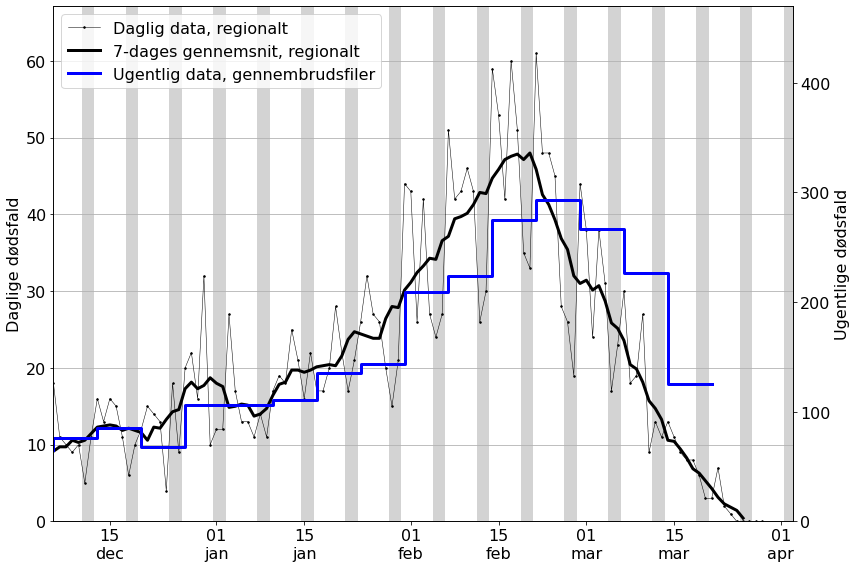

In [109]:
fig,ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(datesDaily,deathsDaily,'k.-',markersize=3,linewidth=0.5,label='Daglig data, regionalt')
ax1.plot(rnTime(datesDaily,7),rnMean(deathsDaily,7),'k',label='7-dages gennemsnit, regionalt')
weekTotDeaths = getTimeSeriesAll(df2_D)
# ax2.step(weekDTs,weekTotDeaths,'b',label='Ugentlige data, gennembrudsfiler')
ax1.step(weekDTs,weekTotDeaths/7,'b',where='pre',label='Ugentlig data, gennembrudsfiler')

ax1.set_xlim(left=weekDTs[0],right=datesDaily[-1]+np.timedelta64(5,'D'))

ax1.set_ylabel('Daglige dødsfald')
ax2.set_ylabel('Ugentlige dødsfald')

ax1.set_ylim(bottom=0)
ax1.set_ylim(top=np.max(deathsDaily[-50:])*1.1)

ax1.legend()

curylim = ax1.get_ylim()
ax2.set_ylim(0,curylim[1]*7)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.grid(axis='y')

fig.tight_layout()

if saveFigures:
    plt.savefig(path_figs+'Regionalt\\DeathsComparison')

# Ugentlige dødsfald, fordelt på alder

In [110]:
ageGroupsGrouped = [ageGroups[0:5],ageGroups[5:7],ageGroups[7:10],ageGroups[10],ageGroups[11]]
ageGroupsGroupedNames = ['0-29','30-49','50-69','70-79','80+']
print(ageGroupsGrouped)
print(ageGroupsGroupedNames)

[array(['0-5', '6-11', '12-15', '16-19', '20-29'], dtype=object), array(['30-39', '40-49'], dtype=object), array(['50-59', '60-64', '65-69'], dtype=object), '70-79', '80+']
['0-29', '30-49', '50-69', '70-79', '80+']


In [111]:
firstDate = weekDTs[0]

In [112]:
display(df2_D)
display(df3_D)

,Aldersgruppe,Uge 12-2022_Ingen vaccination,Uge 12-2022_Første vaccination,Uge 12-2022_Anden vaccination,Uge 12-2022_Fuld effekt efter primært forløb,Uge 12-2022_Fuld effekt efter revaccination,Uge 11-2022_Ingen vaccination,Uge 11-2022_Første vaccination,Uge 11-2022_Anden vaccination,Uge 11-2022_Fuld effekt efter primært forløb,...,Uge 50-2021_Ingen vaccination,Uge 50-2021_Første vaccination,Uge 50-2021_Anden vaccination,Uge 50-2021_Fuld effekt efter primært forløb,Uge 50-2021_Fuld effekt efter revaccination,Uge 49-2021_Ingen vaccination,Uge 49-2021_Første vaccination,Uge 49-2021_Anden vaccination,Uge 49-2021_Fuld effekt efter primært forløb,Uge 49-2021_Fuld effekt efter revaccination
0,0-5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12-15,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,16-19,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,30-39,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6,40-49,0,0,1,0,1,0,0,1,1,...,1,0,0,0,0,0,1,1,1,0
7,50-59,0,0,2,0,2,0,0,7,0,...,1,0,2,2,0,1,0,3,2,1
8,60-64,1,0,2,0,2,0,0,7,0,...,2,0,2,2,0,0,0,1,1,0
9,65-69,0,0,9,3,6,1,0,10,1,...,2,0,3,3,0,1,0,3,1,2


,Aldersgruppe,Uge 12-2022_Ingen vaccination,Uge 12-2022_Første vaccination,Uge 12-2022_Anden vaccination,Uge 12-2022_Fuld effekt efter primært forløb,Uge 12-2022_Fuld effekt efter revaccination,Uge 11-2022_Ingen vaccination,Uge 11-2022_Første vaccination,Uge 11-2022_Anden vaccination,Uge 11-2022_Fuld effekt efter primært forløb,...,Uge 50-2021_Ingen vaccination,Uge 50-2021_Første vaccination,Uge 50-2021_Anden vaccination,Uge 50-2021_Fuld effekt efter primært forløb,Uge 50-2021_Fuld effekt efter revaccination,Uge 49-2021_Ingen vaccination,Uge 49-2021_Første vaccination,Uge 49-2021_Anden vaccination,Uge 49-2021_Fuld effekt efter primært forløb,Uge 49-2021_Fuld effekt efter revaccination
0,0-5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6-11,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12-15,0.0,0,0.0,0.0,0.0,0.0,0.0,1.2,1.2,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16-19,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.2,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20-29,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,30-39,0.0,0,0.4,1.3,0.0,0.0,0.0,0.3,1.1,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,40-49,0.0,0,0.3,0.0,0.3,0.0,0.0,0.3,2.5,...,1.6,0,0.0,0.0,0.0,0.0,9.2,0.2,0.2,0.0
7,50-59,0.0,0,0.4,0.0,0.4,0.0,0.0,1.3,0.0,...,2.1,0,0.3,0.3,0.0,2.1,0.0,0.4,0.3,1.4
8,60-64,9.2,0,0.8,0.0,0.8,0.0,0.0,2.7,0.0,...,13.2,0,0.6,0.7,0.0,0.0,0.0,0.3,0.4,0.0
9,65-69,0.0,0,3.6,45.7,2.5,11.1,0.0,3.8,14.7,...,17.9,0,1.0,1.2,0.0,8.8,0.0,1.0,0.4,5.0


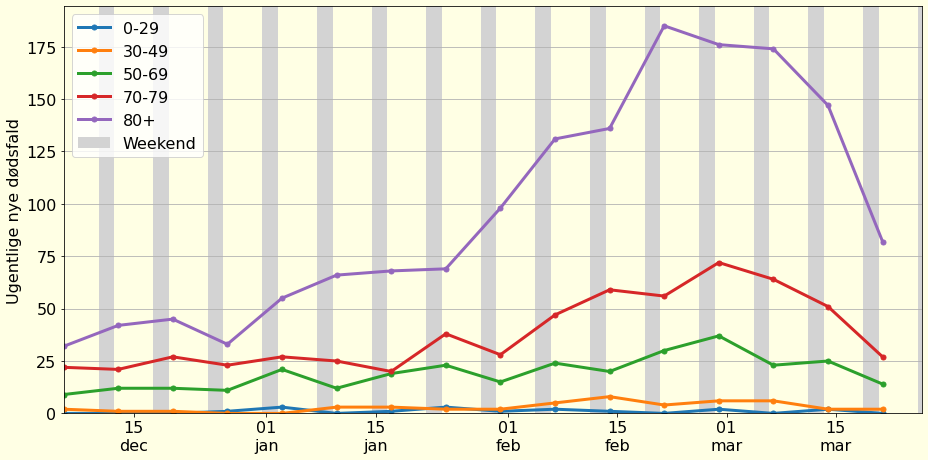

In [113]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    curDeaths = getTimeSeriesAll(df2_D,curAge=curAge)
    ax1.plot(weekDTs,curDeaths,'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Ugentlige nye dødsfald')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
     
fig.tight_layout()


fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeekly')

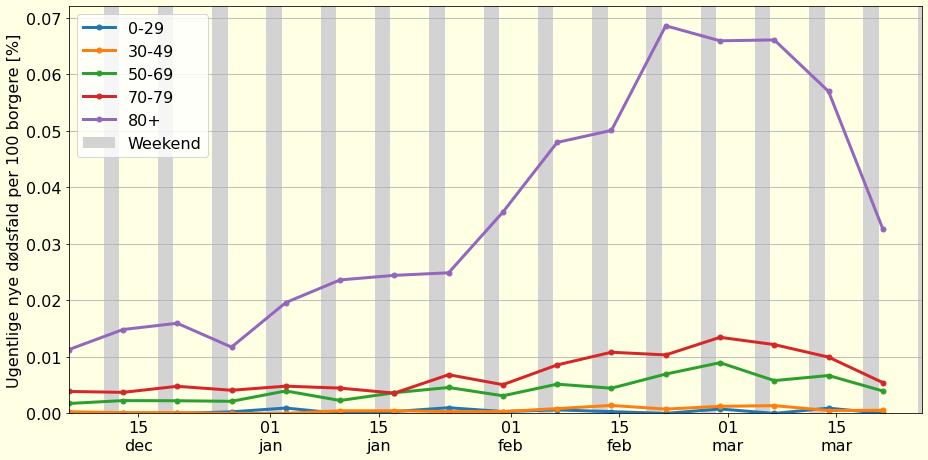

In [114]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    # curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
    curDeaths = getTimeSeriesAllIncidence(df2_D,curAge=curAge)
    ax1.plot(weekDTs,curDeaths/1000,'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Ugentlige nye dødsfald per 100 borgere [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
     
fig.tight_layout()

# ax1.text(weekDTs[4],0.7,'ERROR IN SCRIPT,\nPLEASE IGNORE THIS FIGURE FOR NOW!',fontsize=30)

fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed')

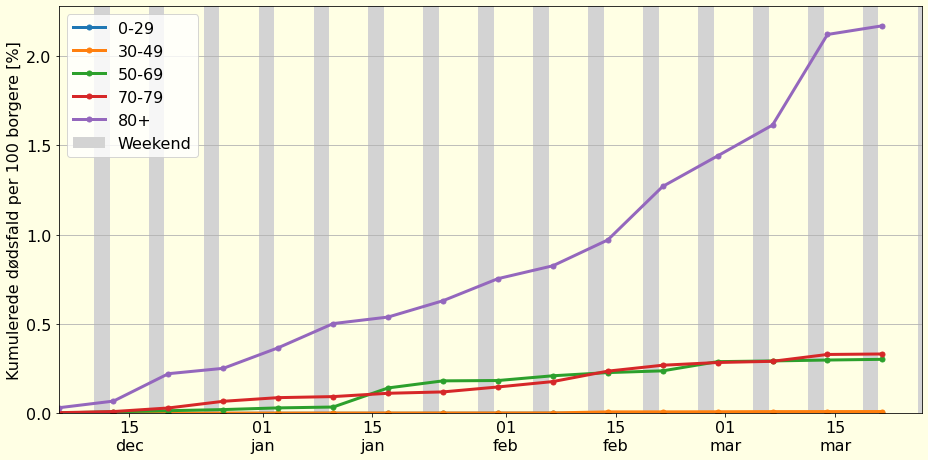

In [115]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    # curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
    curDeaths = getTimeSeriesAllIncidence(df3_D,curAge=curAge)
    ax1.plot(weekDTs,np.cumsum(curDeaths/1000),'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Kumulerede dødsfald per 100 borgere [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
     
fig.tight_layout()


fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed_Cumulated')

In [116]:
# fig,ax1 = plt.subplots(figsize=(13,6.5))
# fig.patch.set_facecolor('xkcd:off white')
# ax1.set_facecolor('xkcd:off white')

# # curAge = ageGroups[-3]
# # curAge
# # for curAge in ageGroupsGrouped:
# for i in range(len(ageGroupsGrouped)):
#     curAge = ageGroupsGrouped[i]
#     curName = ageGroupsGroupedNames[i]

#     curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
#     ax1.plot(weekDTs,curDeaths,'.-',label=curName)
#     # if (np.sum(curDeaths) > 0):
#     #     ax1.plot(weekDTs,curDeaths,label=curAge)

# # Draw weekends
# firstSunday = np.datetime64('2021-10-03')
# numWeeks = 52
# for k in range(0,numWeeks):
#     curSunday = firstSunday + np.timedelta64(7*k,'D')
#     ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

# ax1.set_ylabel('Ugentlige nye dødsfald per 100.000 borgere')

# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# # ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
# ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
# ax1.set_ylim(bottom=0)
# # ax2.set_ylim(bottom=0)
# ax1.legend(loc='upper left')
# # ax2.legend(loc='upper left')
# ax1.grid(axis='y')
# # ax2.grid(axis='y')

# # smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# # ax1.text(1,-0.15,smalltxt,
# #      horizontalalignment='right',
# #      verticalalignment='top',
# #      transform = ax1.transAxes,
# #      fontsize=10)
     
# fig.tight_layout()


# fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed')

In [117]:
print(getTimeSeries(df3_D,curStatus=sNone,curAge='80+'))
print(getTimeSeries(df3_D,curStatus=sTwo,curAge='80+'))

[ 80.1  93.4  84.7  74.5  88.5 129.2  78.8  93.6 311.6 151.4 167.8 169.7
 186.5 175.2 133.6  91. ]
[ 9.1 12.4 12.8  9.9 16.9 19.9 23.  22.7 28.1 45.3 46.6 64.9 62.5 62.9
 53.  31.1]


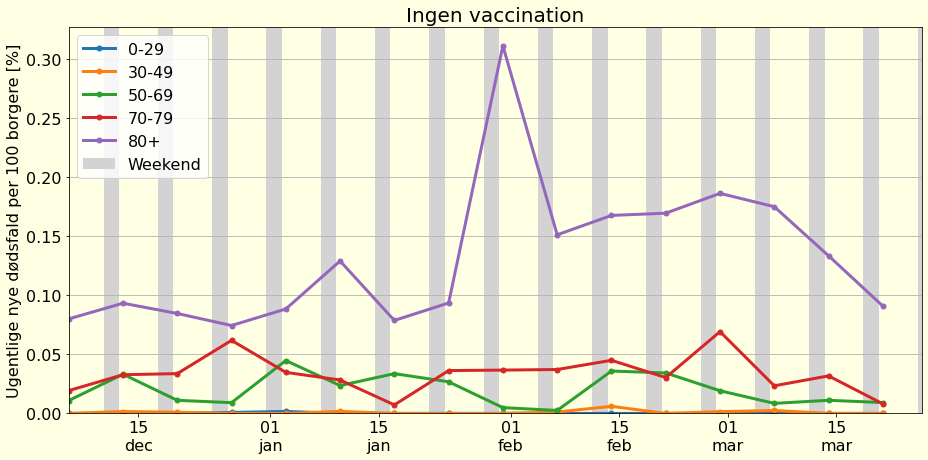

In [118]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    # curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
    curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
    # ax1.plot(weekDTs,curDeaths,'.-',label=curName)
    ax1.plot(weekDTs,curDeaths/1000,'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

ax1.set_title('Ingen vaccination')

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Ugentlige nye dødsfald per 100.000 borgere')
ax1.set_ylabel('Ugentlige nye dødsfald per 100 borgere [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
 
 
deathUvaccYlim = ax1.get_ylim()     
     
fig.tight_layout()


fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed_IngenVaccination')

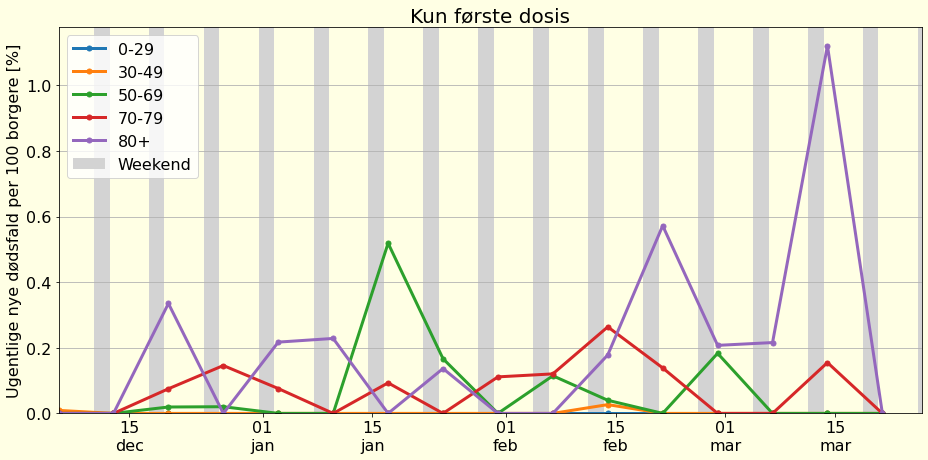

In [119]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    # curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
    curDeaths = getTimeSeries(df3_D,curStatus=sOne,curAge=curAge)
    # ax1.plot(weekDTs,curDeaths,'.-',label=curName)
    ax1.plot(weekDTs,curDeaths/1000,'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

ax1.set_title('Kun første dosis')

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Ugentlige nye dødsfald per 100.000 borgere')
ax1.set_ylabel('Ugentlige nye dødsfald per 100 borgere [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
 
 
# deathUvaccYlim = ax1.get_ylim()     
     
fig.tight_layout()


fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed_EnDosis')

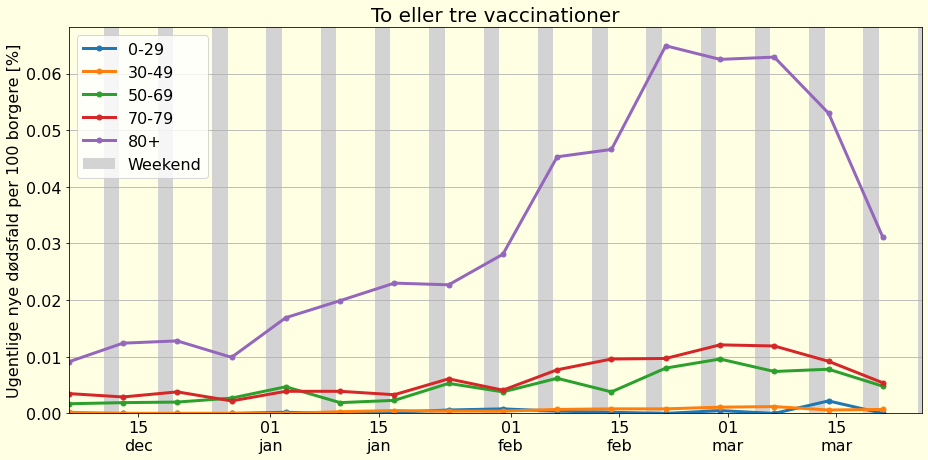

In [120]:
fig,ax1 = plt.subplots(figsize=(13,6.5))
fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

# curAge = ageGroups[-3]
# curAge
# for curAge in ageGroupsGrouped:
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    # curDeaths = getTimeSeriesAll(df3_D,curAge=curAge)
    curDeaths = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)
    # ax1.plot(weekDTs,curDeaths,'.-',label=curName)
    ax1.plot(weekDTs,curDeaths/1000,'.-',label=curName)
    # if (np.sum(curDeaths) > 0):
    #     ax1.plot(weekDTs,curDeaths,label=curAge)

ax1.set_title('To eller tre vaccinationer')

# Draw weekends
firstSunday = np.datetime64('2021-10-03')
numWeeks = 52
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')

ax1.set_ylabel('Ugentlige nye dødsfald per 100.000 borgere')
ax1.set_ylabel('Ugentlige nye dødsfald per 100 borgere [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax1.set_xlim(left=firstDate,right=thisdf.Dato.max()+np.timedelta64(5,'D'))
ax1.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')
ax1.grid(axis='y')
# ax2.grid(axis='y')

# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
     
# ax1.set_ylim(top=deathUvaccYlim[1])
fig.tight_layout()


fig.savefig(path_figs+'AgeDistribution\\Agedistribution_DeathsWeeklyNormed_TwoOrMoreVacc')

# Make bar graph of both age and vacc-status

In [121]:

# curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# inci_unvacc = curDeaths[-4:].sum()
# allInci_unvacc

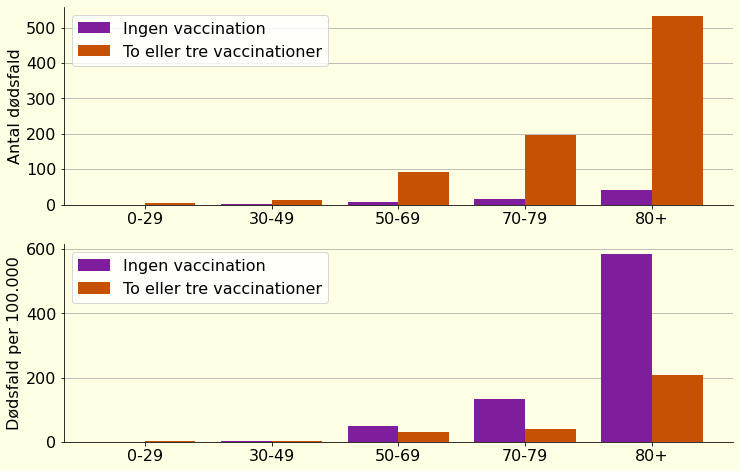

In [122]:

curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)

allCount_unvacc = []
allCount_vacc = []
allInci_unvacc = []
allInci_vacc = []
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]
    
    curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
    count_unvacc = curDeaths[-4:].sum()
    curDeaths = getTimeSeries(df2_D,curStatus=sTwo,curAge=curAge)
    count_vacc = curDeaths[-4:].sum()
    
    curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
    inci_unvacc = curDeaths[-4:].sum()
    curDeaths = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)
    inci_vacc = curDeaths[-4:].sum()
    
    allCount_unvacc.append(count_unvacc)
    allCount_vacc.append(count_vacc)
    allInci_unvacc.append(inci_unvacc)
    allInci_vacc.append(inci_vacc)
    
fig,(ax1,ax2) = plt.subplots(2,1)

fig.patch.set_facecolor('xkcd:off white')
for ax in (ax1,ax2):
    ax.set_facecolor('xkcd:off white')
    
curX = np.arange(len(ageGroupsGroupedNames))
ax1.bar(curX-0.2,allCount_unvacc,width=0.4,color='xkcd:purple',label='Ingen vaccination')
ax1.bar(curX+0.2,allCount_vacc,width=0.4,color='xkcd:dark orange',label='To eller tre vaccinationer')
ax1.set_xticks(curX)
ax1.set_xticklabels(ageGroupsGroupedNames)

ax2.bar(curX-0.2,allInci_unvacc,width=0.4,color='xkcd:purple',label='Ingen vaccination')
ax2.bar(curX+0.2,allInci_vacc,width=0.4,color='xkcd:dark orange',label='To eller tre vaccinationer')
ax2.set_xticks(curX)
ax2.set_xticklabels(ageGroupsGroupedNames)

ax1.set_ylabel('Antal dødsfald')
ax2.set_ylabel('Dødsfald per 100.000')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y')
ax2.grid(axis='y')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

In [123]:
# 100000*np.array(allCount_unvacc)/np.array(allInci_unvacc)

# def estimatePopCount(curStatus,curAge,firstIndex=-4):
#     if (type(curAge)==str):
#         curCase = getTimeSeries(df2_C,curStatus=curStatus,curAge=curAge)
#         curInci = getTimeSeries(df3_C,curStatus=curStatus,curAge=curAge)

#         curPopCount = 100000*curCase/curInci
#         # print(curPopCount)
#         avgPopCount = np.mean(curPopCount[firstIndex:])
#         avgPopCount
        
#         return avgPopCount
#     else:
#         totPopCount = 0
#         for thisAge in curAge:
#             curCase = getTimeSeries(df2_C,curStatus=curStatus,curAge=thisAge)
#             curInci = getTimeSeries(df3_C,curStatus=curStatus,curAge=thisAge)

#             curPopCount = 100000*curCase/curInci
#             avgPopCount = np.mean(curPopCount[firstIndex:])
            
#             totPopCount = totPopCount + avgPopCount 
#         return totPopCount
        
def estimatePopCountArray(curStatus,curAge):
    if (type(curAge)==str):
        curCase = getTimeSeries(df2_T,curStatus=curStatus,curAge=curAge)
        curInci = getTimeSeries(df3_T,curStatus=curStatus,curAge=curAge)

        curPopCount = 100000*curCase/curInci
        
        return curPopCount
    else:
        
        DoneWithFirst = False
        for thisAge in curAge:
            curCase = getTimeSeries(df2_T,curStatus=curStatus,curAge=thisAge)
            curInci = getTimeSeries(df3_T,curStatus=curStatus,curAge=thisAge)

            curPopCount = 100000*curCase/curInci
            # avgPopCount = np.mean(curPopCount[-4:])
            
            if (DoneWithFirst == False):
                totPopCount = curPopCount 
                DoneWithFirst = True
            else:            
                totPopCount = totPopCount + curPopCount 
        return totPopCount
        
def estimatePopCount(curStatus,curAge,firstIndex=-4):
    return np.mean(estimatePopCountArray(curStatus,curAge)[firstIndex:])
        
# estimatePopCount(sTwo,'80+')
# estimatePopCount(sNone,['50-59','60-64','65-69'])
# getTimeSeries(df3_D,curStatus=sNone,curAge=['50-59','60-64','65-69'])[-4:].sum()
print(estimatePopCountArray(sNone,['50-59','60-64','65-69']))
print(np.mean(estimatePopCountArray(sNone,['50-59','60-64','65-69'])[-4:]))
estimatePopCount(sNone,['50-59','60-64','65-69'])

[81425.86181228 79963.05692291 78513.84704395 77467.11302902
 76906.86150086 76298.86343012 75845.10624275 75508.98957383
 75338.03002137 75226.02620419 75169.68792448 75106.77759638
 75055.48933055 75004.55260747 74985.72561611 74957.23933089]
75000.75172125635


75000.75172125635

In [124]:
# testAge = '50-59'
# testAge = '60-64'
# print(estimatePopCount(sNone,testAge))
# print(getTimeSeries(df2_D,curStatus=sNone,curAge=testAge))
# print(getTimeSeries(df2_D,curStatus=sNone,curAge=testAge)[-4:].sum())
# print(getTimeSeries(df3_D,curStatus=sNone,curAge=testAge))
# print(getTimeSeries(df3_D,curStatus=sNone,curAge=testAge)[-4:].sum())

# 100000*getTimeSeries(df2_C,curStatus=sNone,curAge=testAge)/getTimeSeries(df3_C,curStatus=sNone,curAge=testAge)

# 100000*4/13552

def getIncidenceSum(data='Deaths',curStatus=sNone,curAge='Alle',startIndex=0):
    if data=='Deaths':
        thisdf_2 = df2_D 
        thisdf_3 = df3_D 
    else:
        thisdf_2 = df2_C
        thisdf_3 = df3_C
        
    if (type(curAge)==str):
        return getTimeSeries(thisdf_3,curStatus,curAge)[startIndex:].sum()
    else:
        curTotCount = getTimeSeries(thisdf_2,curStatus,curAge)[startIndex:].sum()
        curPopEsti = estimatePopCount(curStatus,curAge)
        
        return 100000 * curTotCount / curPopEsti
        
print(estimatePopCount(sNone,'50-59'))
print(estimatePopCount(sNone,'60-64'))
print(estimatePopCount(sNone,'65-69'))
print(getIncidenceSum('Deaths',sNone,'50-59',-4))
print(getIncidenceSum('Deaths',sNone,'60-64',-4))
print(getIncidenceSum('Deaths',sNone,'65-69',-4))
print(getIncidenceSum('Deaths',sNone,['50-59','60-64','65-69'],-4))

48858.0423946068
15298.376112569831
10844.333214079728
8.6
17.7
21.7
9.333239786736822


In [125]:
# testAge = ['50-59','60-64','65-69']
# # testAge = '65-69'
# print(getTimeSeries(df3_D,curStatus=sNone,curAge=testAge))
# print(getTimeSeries(df3_D,curStatus=sNone,curAge=testAge)[-4:].sum())
# print(getTimeSeries(df2_D,curStatus=sNone,curAge=testAge))
# print(getTimeSeries(df2_D,curStatus=sNone,curAge=testAge)[-4:].sum())

# print(estimatePopCount(sNone,testAge))

# 100000*44/7400
# 100000*9/41400
# 100000*4/13552
# 100000*4/10120
# (100000*9/41400) +(100000*4/13552) +(100000*4/10120) 
# (41400) +(13552) +(10120) 
# 100000*(4+4+9)/(41400+13552+10120)
# # 100000*17/90.2


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\597013461.py:41: RuntimeWarning: invalid value encountered in true_divide
  curPopCount = 100000*curCase/curInci
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\1388851903.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


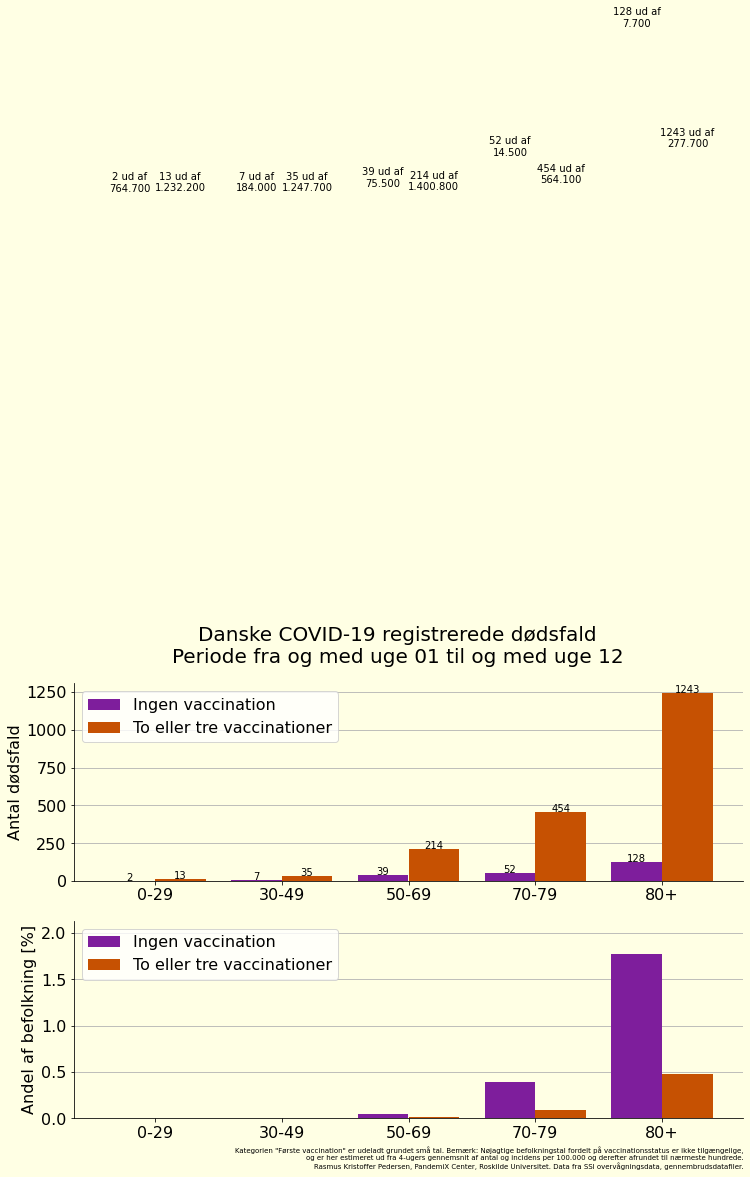

In [126]:
# Same figure as above, but with labels with population counts

firstIndexToUse = np.where([x == '01' for x in weekNamesShort])[0][0]

curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)

allCount_unvacc = []
allCount_vacc = []
allInci_unvacc = []
allInci_vacc = []

popCounts_unvacc = []
popCounts_vacc = []
for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]
    
    curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
    count_unvacc = curDeaths[firstIndexToUse:].sum()
    curDeaths = getTimeSeries(df2_D,curStatus=sTwo,curAge=curAge)
    count_vacc = curDeaths[firstIndexToUse:].sum()
    
    # curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
    # inci_unvacc = curDeaths[firstIndexToUse:].sum()
    # curDeaths = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)
    # inci_vacc = curDeaths[firstIndexToUse:].sum()
    inci_unvacc = getIncidenceSum('Deaths',sNone,curAge,firstIndexToUse)
    inci_vacc = getIncidenceSum('Deaths',sTwo,curAge,firstIndexToUse)
    
    # Scale to % instead of per 100.000
    inci_unvacc = inci_unvacc/1000
    inci_vacc = inci_vacc/1000
    
    allCount_unvacc.append(count_unvacc)
    allCount_vacc.append(count_vacc)
    allInci_unvacc.append(inci_unvacc)
    allInci_vacc.append(inci_vacc)
    
    # popCounts_unvacc.append(estimatePopCount(sNone,curAge))
    # popCounts_vacc.append(estimatePopCount(sTwo,curAge))
    popCounts_unvacc.append(estimatePopCount(sNone,curAge,firstIndexToUse))
    popCounts_vacc.append(estimatePopCount(sTwo,curAge,firstIndexToUse))
    
fig,(ax1,ax2) = plt.subplots(2,1)

fig.patch.set_facecolor('xkcd:off white')
for ax in (ax1,ax2):
    ax.set_facecolor('xkcd:off white')

dX = 0.2
    
curX = np.arange(len(ageGroupsGroupedNames))
ax1.bar(curX-dX,allCount_unvacc,width=2*dX,color='xkcd:purple',label='Ingen vaccination')
ax1.bar(curX+dX,allCount_vacc,width=2*dX,color='xkcd:dark orange',label='To eller tre vaccinationer')
ax1.set_xticks(curX)
ax1.set_xticklabels(ageGroupsGroupedNames)

ax2.bar(curX-dX,allInci_unvacc,width=2*dX,color='xkcd:purple',label='Ingen vaccination')
ax2.bar(curX+dX,allInci_vacc,width=2*dX,color='xkcd:dark orange',label='To eller tre vaccinationer')
ax2.set_xticks(curX)
ax2.set_xticklabels(ageGroupsGroupedNames)


# Round popcounts to nearest hundred
popCounts_unvacc = [int(np.round(x/100))*100 for x in popCounts_unvacc]
popCounts_vacc = [int(np.round(x/100))*100 for x in popCounts_vacc]
# popCounts_unvacc = [int(np.round(x/1000))*1000 for x in popCounts_unvacc]
# popCounts_vacc = [int(np.round(x/1000))*1000 for x in popCounts_vacc]
# popCounts_unvacc = [int(np.round(x/1000)) for x in popCounts_unvacc]
# popCounts_vacc = [int(np.round(x/1000)) for x in popCounts_vacc]
# Add counts to figure
for i in curX:
    ax1.text(i-dX,allCount_unvacc[i]+2,allCount_unvacc[i],ha='center')
    ax1.text(i+dX,allCount_vacc[i]+2,allCount_vacc[i],ha='center')
    
    curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]:n}'
    ax2.text(i-dX,allInci_unvacc[i]+10,curStr,ha='center')
    curStr = f'{allCount_vacc[i]} ud af\n{popCounts_vacc[i]:n}'
    ax2.text(i+dX,allInci_vacc[i]+10,curStr,ha='center')
    # curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]} tusind'
    # ax2.text(i-dX,allInci_unvacc[i]+10,curStr,ha='center')
    # curStr = f'{allCount_vacc[i]} ud af\n{popCounts_vacc[i]} tusind'
    # ax2.text(i+dX,allInci_vacc[i]+10,curStr,ha='center')

ax2.set_ylim(top=allInci_unvacc[-1]*1.2)

ax1.set_ylabel('Antal dødsfald')
# ax2.set_ylabel('Dødsfald per 100.000')
ax2.set_ylabel('Andel af befolkning [%]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y')
ax2.grid(axis='y')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

strTitle = f'Danske COVID-19 registrerede dødsfald\nPeriode fra og med uge {weekNamesShort[firstIndexToUse]} til og med uge {weekNamesShort[-1]}'
fig.suptitle(strTitle,fontsize=20)

txt1 = 'Kategorien "Første vaccination" er udeladt grundet små tal. Bemærk: Nøjagtige befolkningstal fordelt på vaccinationsstatus er ikke tilgængelige,\nog er her estimeret ud fra 4-ugers gennemsnit af antal og incidens per 100.000 og derefter afrundet til nærmeste hundrede.\nRasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet. Data fra SSI overvågningsdata, gennembrudsdatafiler.'
ax2.text(1, -0.14,txt1,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax2.transAxes,
     fontsize=7)
     
fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'AgeDistribution\\DoesdfaldPerVaccinestatusOgAlder')

In [127]:
allInci_unvacc * np.array(popCounts_vacc) / 100000
diffInci = np.array(allInci_unvacc)/np.array(allInci_vacc)
deathsEstiTot = diffInci * np.array(allCount_vacc)
deathsEstiTotRound = np.array([int(np.round(x)) for x in deathsEstiTot])
deathsDiffRound = deathsEstiTotRound - allCount_vacc
# deathsAvoid = deathsEstiTot -allCount_vacc
# deathsDiffRound = np.array([int(np.round(x)) for x in deathsAvoid])

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\2241437044.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


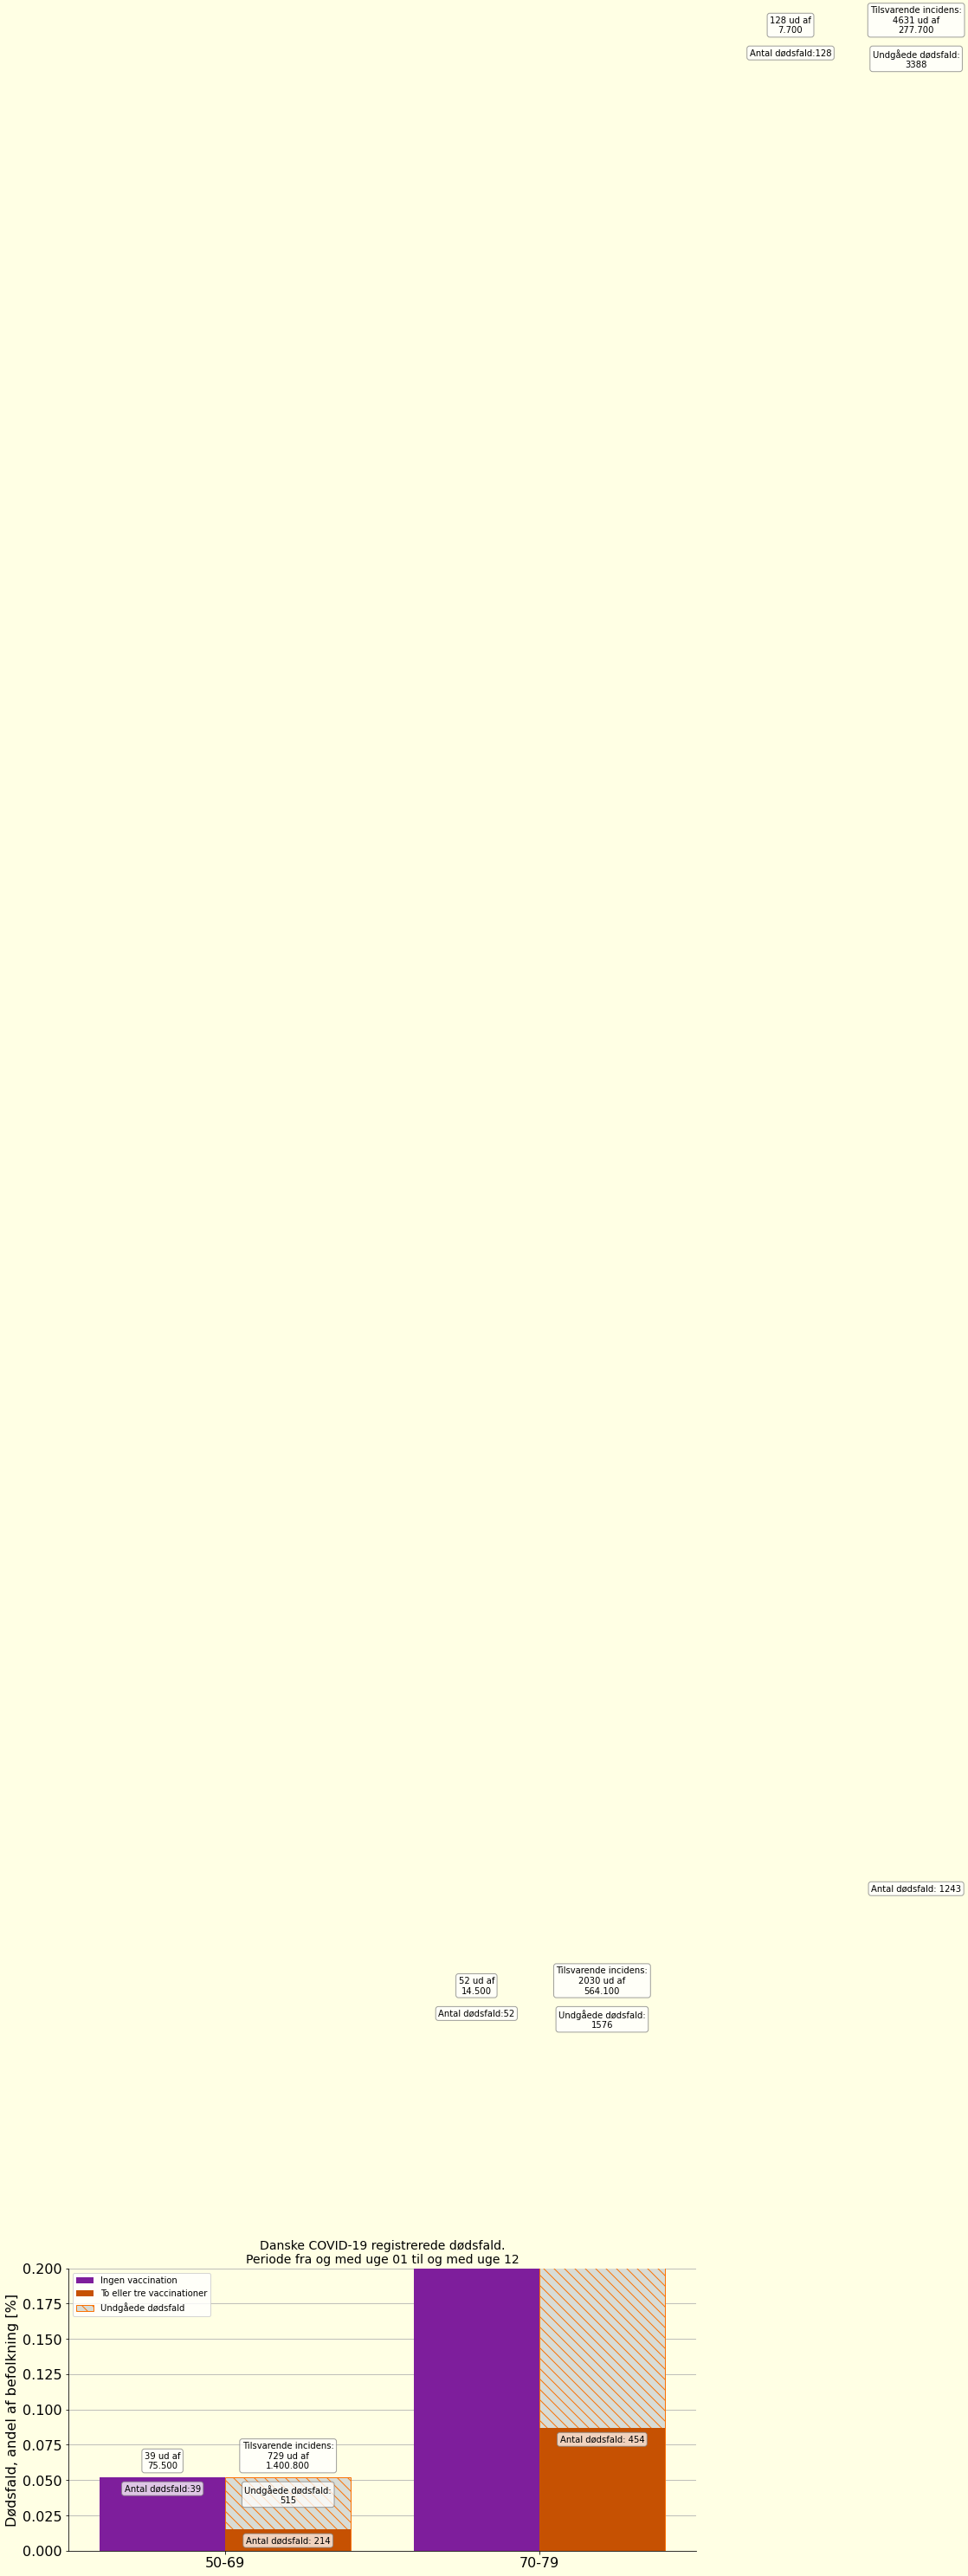

In [128]:
# Comparison of deaths in vacc and unvacc groups, and estimate of number of deaths avoided

fig,ax1 = plt.subplots(figsize=(13,6))

fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')

dX = 0.2
    
ax1.bar(curX-dX,allInci_unvacc,width=2*dX,color='xkcd:purple',label='Ingen vaccination')
ax1.bar(curX+dX,allInci_vacc,width=2*dX,color='xkcd:dark orange',label='To eller tre vaccinationer',zorder=3)
ax1.bar(curX+dX,allInci_unvacc,width=2*dX,color='xkcd:light grey',label='Undgåede dødsfald',zorder=2,hatch='\\\\',edgecolor='xkcd:orange')
ax1.set_xticks(curX)
ax1.set_xticklabels(ageGroupsGroupedNames)


bboxStyle = dict(facecolor='white',alpha=0.75, edgecolor='grey', boxstyle='round')
curOffset = 5/1000
# Add counts to figure
# for i in curX:
for i in curX[2:]:
    # ax1.text(i-dX,allCount_unvacc[i]+2,allCount_unvacc[i],ha='center')
    # ax1.text(i+dX,allCount_vacc[i]+2,allCount_vacc[i],ha='center')
    
    curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]:n}'
    ax1.text(i-dX,allInci_unvacc[i]+curOffset,curStr,ha='center',va='bottom',bbox=bboxStyle)
    curStr = f'Antal dødsfald:{allCount_unvacc[i]}'
    ax1.text(i-dX,allInci_unvacc[i]-curOffset,curStr,ha='center',va='top',bbox=bboxStyle)
    
    curStr = f'Tilsvarende incidens:\n{np.round(deathsEstiTotRound[i]):.0f} ud af\n{popCounts_vacc[i]:n}'
    ax1.text(i+dX,allInci_unvacc[i]+curOffset,curStr,ha='center',va='bottom',bbox=bboxStyle)
    
    curStr = f'Antal dødsfald: {allCount_vacc[i]}'
    ax1.text(i+dX,allInci_vacc[i]-curOffset,curStr,ha='center',va='top',bbox=bboxStyle)
    curStr = f'Undgåede dødsfald:\n{deathsDiffRound[i]}'
    ax1.text(i+dX,allInci_unvacc[i]-curOffset,curStr,ha='center',va='top',bbox=bboxStyle)
    # curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]} tusind'
    # ax2.text(i-dX,allInci_unvacc[i]+10,curStr,ha='center')
    # curStr = f'{allCount_vacc[i]} ud af\n{popCounts_vacc[i]} tusind'
    # ax2.text(i+dX,allInci_vacc[i]+10,curStr,ha='center')

# ax2.set_ylim(top=allInci_unvacc[-1]*1.2)

ax1.set_ylabel('Dødsfald per 100.000')
ax1.set_ylabel('Dødsfald, andel af befolkning [%]')
ax1.legend(loc='upper left',fontsize=10)

ax1.set_axisbelow(True)
ax1.grid(axis='y')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

strTitle = f'Danske COVID-19 registrerede dødsfald.\nPeriode fra og med uge {weekNamesShort[firstIndexToUse]} til og med uge {weekNamesShort[-1]}'
ax1.set_title(strTitle,fontsize=14)

# txt1 = 'Kategorien "Første vaccination" er udeladt grundet små tal. Bemærk: Nøjagtige befolkningstal fordelt på vaccinationsstatus er ikke tilgængelige,\nog er her estimeret ud fra 4-ugers gennemsnit af antal og incidens per 100.000 og derefter afrundet til nærmeste hundrede.\nRasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet. Data fra SSI overvågningsdata, gennembrudsdatafiler.'
# ax2.text(1, -0.14,txt1,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax2.transAxes,
#      fontsize=7)

ax1.set_xlim([1.5,4.5])
# ax1.set_ylim([0,690])
# ax1.set_ylim([0,690/1000])
ax1.set_ylim([0,0.8])
if saveFigures:
    fig.savefig(path_figs+'AgeDistribution\\Doesdfaldundgaaet_50+')

ax1.set_xlim([3.5,4.5])

if saveFigures:
    fig.savefig(path_figs+'AgeDistribution\\Doesdfaldundgaaet_80+')
    
ax1.set_xlim([1.5,3.5])
# ax1.set_ylim([0,150])
# ax1.set_ylim([0,150/1000])
ax1.set_ylim([0,0.20])
     
fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'AgeDistribution\\Doesdfaldundgaaet_50_79')

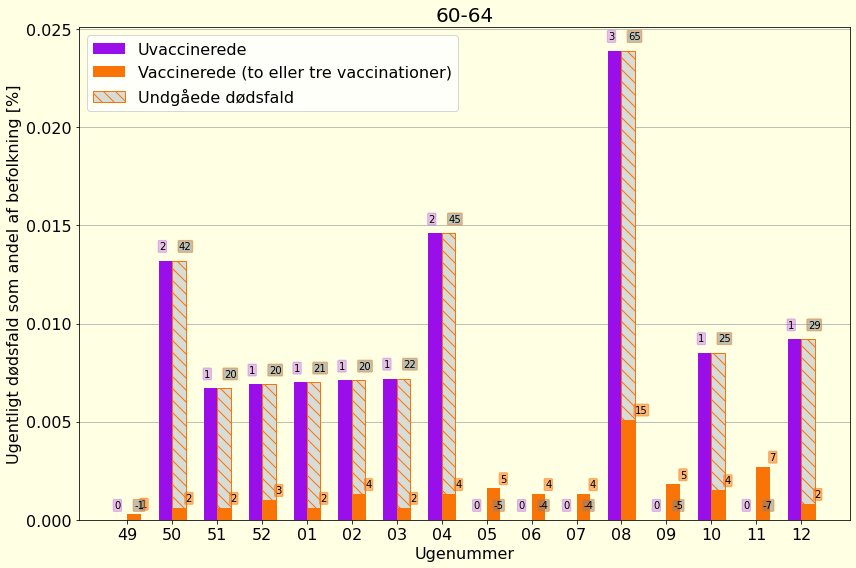

In [129]:
# Week for week comparison
curAge = '80+'
curAge = '70-79'
curAge = '65-69'
curAge = '60-64'

curDeaths_unvacc = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
curDeaths_vacc = getTimeSeries(df2_D,curStatus=sTwo,curAge=curAge)

curInci_unvacc = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
curInci_vacc = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)

# Scale to % instead of per 100.000
curInci_unvacc = curInci_unvacc/1000
curInci_vacc = curInci_vacc/1000

curInci_vacc


popCount_unvacc = estimatePopCountArray(sNone,curAge)
popCount_vacc = estimatePopCountArray(sTwo,curAge)

# print(100*curDeaths_unvacc/popCount_unvacc)
# print(curInci_unvacc)


# print(np.round(curInci_unvacc * popCount_unvacc / 100))
# print(curDeaths_unvacc)
# print(np.round(curInci_unvacc * popCount_vacc / 100))
# print(curDeaths_vacc)

totCount_vaccLikeUnvacc = np.round(curInci_unvacc * popCount_vacc / 100)

# fig,ax1 = plt.subplots()

# ax1.plot(weekNamesShort,curDeaths_vacc)
# ax1.plot(weekNamesShort,totCount_vaccLikeUnvacc)
# ax1.plot(weekNamesShort,curInci_unvacc)
# ax1.plot(weekNamesShort,curInci_vacc)

fig,ax1 = plt.subplots()

fig.patch.set_facecolor('xkcd:off white')
ax1.set_facecolor('xkcd:off white')
    
dX = 0.15
curX = np.arange(len(weekNamesShort))
ax1.bar(curX-dX,curInci_unvacc,width=2*dX,color='xkcd:violet',label='Uvaccinerede')
ax1.bar(curX+dX,curInci_vacc,width=2*dX,color='xkcd:orange',zorder=3,label='Vaccinerede (to eller tre vaccinationer)')
ax1.bar(curX+dX,curInci_unvacc,width=2*dX,color='xkcd:light grey',label='Undgåede dødsfald',zorder=2,hatch='\\\\',edgecolor='xkcd:orange')


bboxStyleUnva = dict(facecolor='xkcd:violet',alpha=0.25, edgecolor='xkcd:violet', boxstyle='round',pad=0.1)
bboxStyleAvoi = dict(facecolor='grey',alpha=0.5, edgecolor='xkcd:orange', boxstyle='round',pad=0.1)
bboxStyleVacc = dict(facecolor='xkcd:orange',alpha=0.5, edgecolor='xkcd:orange', boxstyle='round',pad=0.1)
yOffset = 0.0025
yOffset = np.max(curInci_unvacc)/50

showAnnotation = False
# showAnnotation = True
for i in curX:
    ax1.text(i-dX,curInci_unvacc[i]+yOffset,curDeaths_unvacc[i],ha='right',va='bottom',bbox=bboxStyleUnva)
    ax1.text(i+dX*2,curInci_vacc[i]+yOffset/2,curDeaths_vacc[i],ha='left',va='bottom',bbox=bboxStyleVacc)
    ax1.text(i+dX,curInci_unvacc[i]+yOffset,int(totCount_vaccLikeUnvacc[i])-int(curDeaths_vacc[i]),ha='left',va='bottom',bbox=bboxStyleAvoi)
    
    if showAnnotation:
        if (i == 5):
            yOffset2 = 0.01
            ax1.plot([i-dX*2,i-dX*6],[curInci_unvacc[i]+yOffset+yOffset2,curInci_unvacc[i]+yOffset+yOffset2*2],'k',linewidth=1)
            ax1.text(i-dX*6,curInci_unvacc[i]+yOffset+yOffset2*2,'Antal dødsfald\nUvaccinerede',ha='center',va='bottom')
                # showAnnotation = False
                
                
            ax1.plot([i+dX*3,i+dX*5],[curInci_vacc[i]+yOffset+yOffset2,curInci_unvacc[i]+yOffset+yOffset2*2],'k',linewidth=1)
            ax1.text(i+dX*8,curInci_unvacc[i]+yOffset+yOffset2*2,'Antal dødsfald\nVaccinerede',ha='center',va='bottom')
                
            ax1.plot([i+dX*2,i+dX],[curInci_unvacc[i]+yOffset+yOffset2,curInci_unvacc[i]+yOffset+yOffset2*5],'k',linewidth=1)
            ax1.text(i,curInci_unvacc[i]+yOffset+yOffset2*5.5,'Forskel i dødsfald\nhvis incidensen var den samme',ha='center',va='bottom')

ax1.set_ylim(bottom=0)

ax1.set_xticks(curX)
ax1.set_xticklabels(weekNamesShort)

ax1.set_ylabel('Ugentligt dødsfald som andel af befolkning [%]')

ax1.set_axisbelow(True)
ax1.legend(loc='upper left')
ax1.grid(axis='y')

ax1.set_xlabel('Ugenummer')

ax1.set_title(curAge)

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'AgeDistribution\\Doesdfaldundgaaet_UgeForUge'+curAge)

# Make some comparison plots

In [130]:
def addWeekends(ax):
    # Draw weekends
    firstSunday = np.datetime64('2021-10-03')
    numWeeks = 52
    for k in range(0,numWeeks):
        curSunday = firstSunday + np.timedelta64(7*k,'D')
        ax.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')


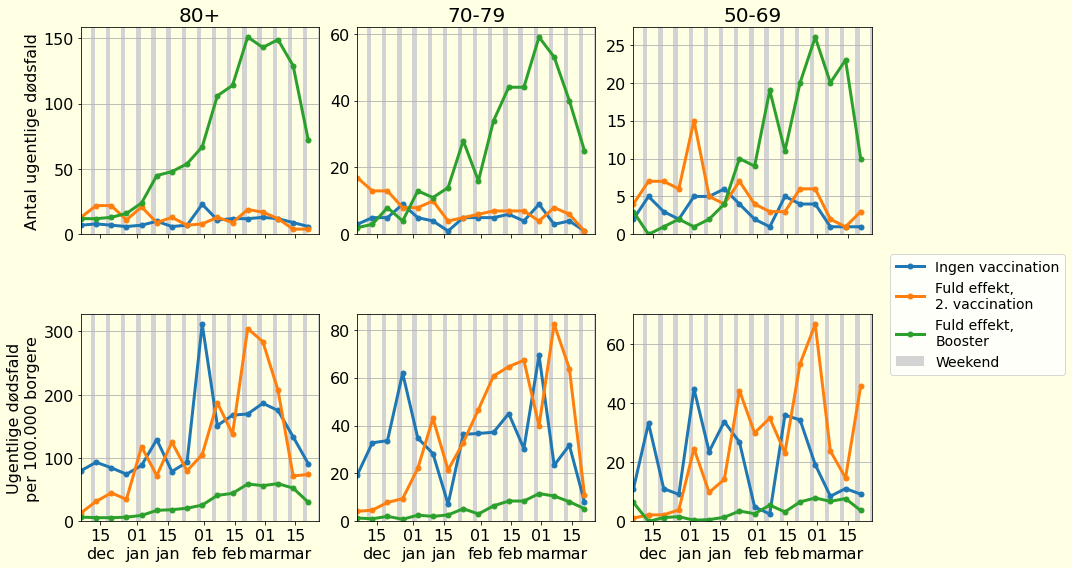

In [131]:


fig,allAxes = plt.subplots(2,3,sharex=True,figsize=(15,8))

fig.patch.set_facecolor('xkcd:off white')
for ax in allAxes.flatten():
    ax.set_facecolor('xkcd:off white')
# ax1.set_facecolor('xkcd:off white')

i = -1
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[0]
curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curAge)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
ax.set_ylabel('Antal ugentlige dødsfald')

ax = allAxes.flatten()[3]
curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')


i = -2
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[1]
curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curAge)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Antal ugentlige dødsfald')

ax = allAxes.flatten()[4]
curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')

i = -3
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[2]
curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curName)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Antal ugentlige dødsfald')

ax = allAxes.flatten()[5]
curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
ax.legend(bbox_to_anchor=(1.05,1),loc='center left',fontsize=14)
# ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
ax.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'AgeDistribution/DeathsVaccStatus')

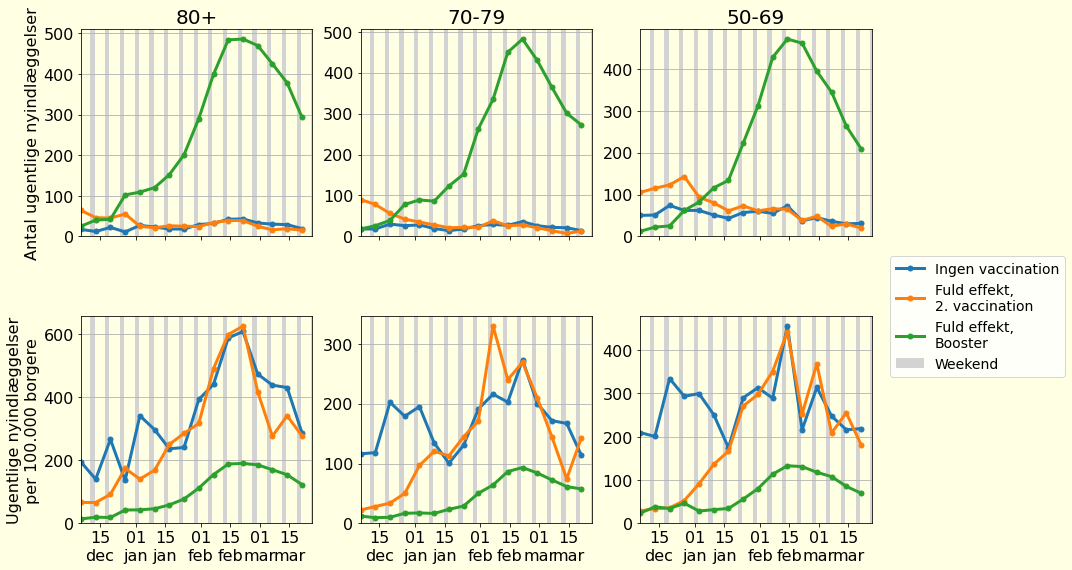

In [132]:


fig,allAxes = plt.subplots(2,3,sharex=True,figsize=(15,8))

fig.patch.set_facecolor('xkcd:off white')
for ax in allAxes.flatten():
    ax.set_facecolor('xkcd:off white')
# ax1.set_facecolor('xkcd:off white')

i = -1
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[0]
curDeaths = getTimeSeries(df2_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curAge)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
ax.set_ylabel('Antal ugentlige nyindlæggelser')

ax = allAxes.flatten()[3]
curDeaths = getTimeSeries(df3_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
ax.set_ylabel('Ugentlige nyindlæggelser\nper 100.000 borgere')


i = -2
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[1]
curDeaths = getTimeSeries(df2_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curAge)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Antal ugentlige dødsfald')

ax = allAxes.flatten()[4]
curDeaths = getTimeSeries(df3_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')

i = -3
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]

ax = allAxes.flatten()[2]
curDeaths = getTimeSeries(df2_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df2_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

ax.set_title(curName)

addWeekends(ax)
ax.set_ylim(bottom=0)
ax.grid(axis='y')
# ax.legend(loc='upper left')
# ax.set_ylabel('Antal ugentlige dødsfald')

ax = allAxes.flatten()[5]
curDeaths = getTimeSeries(df3_H,curStatus=sNone,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sFull,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
curDeaths = getTimeSeries(df3_H,curStatus=sReva,curAge=curAge)
ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
addWeekends(ax)

ax.set_ylim(bottom=0)
ax.grid(axis='y')
ax.legend(bbox_to_anchor=(1.05,1),loc='center left',fontsize=14)
# ax.legend(loc='upper left')
# ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
ax.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))

plt.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'AgeDistribution/AdmsVaccStatus')

# Vaccine effectiveness

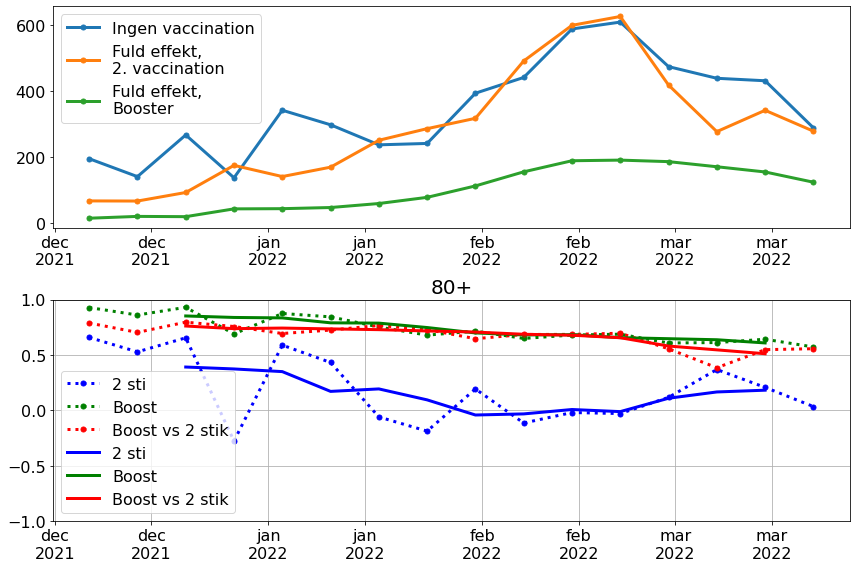

In [133]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))

i = -1
curAge = ageGroupsGrouped[i]
curName = ageGroupsGroupedNames[i]


curDeaths_None = getTimeSeries(df3_H,curStatus=sNone,curAge=curAge)
curDeaths_Full = getTimeSeries(df3_H,curStatus=sFull,curAge=curAge)
curDeaths_Reva = getTimeSeries(df3_H,curStatus=sReva,curAge=curAge)
# curDeaths_None = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# curDeaths_Full = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
# curDeaths_Reva = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
ax1.plot(weekDTs,curDeaths_None,'.-',label='Ingen vaccination')
ax1.plot(weekDTs,curDeaths_Full,'.-',label='Fuld effekt,\n2. vaccination')
ax1.plot(weekDTs,curDeaths_Reva,'.-',label='Fuld effekt,\nBooster')

VE_Full = 1 - (curDeaths_Full/curDeaths_None)
VE_Reva = 1 - (curDeaths_Reva/curDeaths_None)
VE_Boost = 1 - (curDeaths_Reva/curDeaths_Full)

ax2.plot(weekDTs,VE_Full,'b.:',label='2 sti')
ax2.plot(weekDTs,VE_Reva,'g.:',label='Boost')
ax2.plot(weekDTs,VE_Boost,'r.:',label='Boost vs 2 stik')
ax2.plot(rnTime(weekDTs,4),rnMean(VE_Full,4),'b',label='2 sti')
ax2.plot(rnTime(weekDTs,4),rnMean(VE_Reva,4),'g',label='Boost')
ax2.plot(rnTime(weekDTs,4),rnMean(VE_Boost,4),'r',label='Boost vs 2 stik')

ax1.legend()
ax2.legend()
ax2.grid()

ax2.set_title(curName)

ax2.set_ylim([-1,1])

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.tight_layout()

In [134]:


# fig,allAxes = plt.subplots(2,3,sharex=True,figsize=(15,8))

# fig.patch.set_facecolor('xkcd:off white')
# for ax in allAxes.flatten():
#     ax.set_facecolor('xkcd:off white')
# # ax1.set_facecolor('xkcd:off white')

# i = -1
# curAge = ageGroupsGrouped[i]
# curName = ageGroupsGroupedNames[i]

# ax = allAxes.flatten()[0]
# curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

# ax.set_title(curAge)

# addWeekends(ax)
# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# # ax.legend(loc='upper left')
# ax.set_ylabel('Antal ugentlige dødsfald')

# ax = allAxes.flatten()[3]
# curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
# addWeekends(ax)

# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# # ax.legend(loc='upper left')
# ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')


# i = -2
# curAge = ageGroupsGrouped[i]
# curName = ageGroupsGroupedNames[i]

# ax = allAxes.flatten()[1]
# curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

# ax.set_title(curAge)

# addWeekends(ax)
# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# # ax.legend(loc='upper left')
# # ax.set_ylabel('Antal ugentlige dødsfald')

# ax = allAxes.flatten()[4]
# curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
# addWeekends(ax)

# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# # ax.legend(loc='upper left')
# # ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')

# i = -3
# curAge = ageGroupsGrouped[i]
# curName = ageGroupsGroupedNames[i]

# ax = allAxes.flatten()[2]
# curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')

# ax.set_title(curName)

# addWeekends(ax)
# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# # ax.legend(loc='upper left')
# # ax.set_ylabel('Antal ugentlige dødsfald')

# ax = allAxes.flatten()[5]
# curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sFull,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\n2. vaccination')
# curDeaths = getTimeSeries(df3_D,curStatus=sReva,curAge=curAge)
# ax.plot(weekDTs,curDeaths,'.-',label='Fuld effekt,\nBooster')
# addWeekends(ax)

# ax.set_ylim(bottom=0)
# ax.grid(axis='y')
# ax.legend(bbox_to_anchor=(1.05,1),loc='center left',fontsize=14)
# # ax.set_ylabel('Ugentlige dødsfald\nper 100.000 borgere')


# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
# ax.set_xlim(left=firstDate,right=weekDTs[-1]+np.timedelta64(5,'D'))

# fig.tight_layout()

# if saveFigures:
#     fig.savefig(path_figs+'AgeDistribution/DeathsVaccStatus')

# Heatmap

In [135]:
 
def getIncidenceCombined(data='Deaths',curStatus=sNone,curAge='Alle',startIndex=0):
    if data=='Deaths':
        thisdf_2 = df2_D 
        thisdf_3 = df3_D 
    else:
        thisdf_2 = df2_C
        thisdf_3 = df3_C
    if (type(curAge)==str):
        return getTimeSeries(thisdf_3,curStatus,curAge)[startIndex:]
    else:
        curTotCount = getTimeSeries(thisdf_2,curStatus,curAge)[startIndex:]
        # curPopEsti = estimatePopCount(curStatus,curAge)
        curPopEsti = estimatePopCountArray(curStatus,curAge)[startIndex:]
        
        return 100000 * curTotCount / curPopEsti

In [136]:

# curInci = getIncidenceCombined('Deaths',sTwo,curAge=ageGroupsGrouped[1],startIndex=indexToStart)
# df2_C
# estimatePopCountArray(sNone,ageGroupsGrouped[1])
# # estimatePopCount(sFull,'80+')

In [137]:
df_heat_vacc = pd.DataFrame() 
df_heat_unva = pd.DataFrame() 
df_heat_reva = pd.DataFrame() 
df_heat_vacc_count = pd.DataFrame() 
df_heat_unva_count = pd.DataFrame() 
df_heat_reva_count = pd.DataFrame() 
df_heat_vacc_pop = pd.DataFrame() 
df_heat_unva_pop = pd.DataFrame() 
df_heat_reva_pop = pd.DataFrame() 

indexToStart = 6

for i in range(len(ageGroupsGrouped)):
    curAge = ageGroupsGrouped[i]
    curName = ageGroupsGroupedNames[i]

    curInci = getIncidenceCombined('Deaths',sNone,curAge=curAge,startIndex=indexToStart)
    df_heat_unva[curName] = curInci
    curInci = getIncidenceCombined('Deaths',sFull,curAge=curAge,startIndex=indexToStart)
    df_heat_vacc[curName] = curInci
    curInci = getIncidenceCombined('Deaths',sReva,curAge=curAge,startIndex=indexToStart)
    df_heat_reva[curName] = curInci
    
    
    curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)[indexToStart:]
    df_heat_unva_count[curName] = curDeaths
    curDeaths = getTimeSeries(df2_D,curStatus=sFull,curAge=curAge)[indexToStart:]
    df_heat_vacc_count[curName] = curDeaths
    curDeaths = getTimeSeries(df2_D,curStatus=sReva,curAge=curAge)[indexToStart:]
    df_heat_reva_count[curName] = curDeaths
    
    curPopEsti = estimatePopCountArray(sNone,curAge)[indexToStart:]
    df_heat_unva_pop[curName] = curPopEsti
    curPopEsti = estimatePopCountArray(sFull,curAge)[indexToStart:]
    df_heat_vacc_pop[curName] = curPopEsti
    curPopEsti = estimatePopCountArray(sReva,curAge)[indexToStart:]
    df_heat_reva_pop[curName] = curPopEsti

df_heat_reva.tail()

df_heat_unva = df_heat_unva.iloc[:,1:]
df_heat_vacc = df_heat_vacc.iloc[:,1:]
df_heat_reva = df_heat_reva.iloc[:,1:]
df_heat_unva_count = df_heat_unva_count.iloc[:,1:]
df_heat_vacc_count = df_heat_vacc_count.iloc[:,1:]
df_heat_reva_count = df_heat_reva_count.iloc[:,1:]
df_heat_unva_pop = df_heat_unva_pop.iloc[:,1:]
df_heat_vacc_pop = df_heat_vacc_pop.iloc[:,1:]
df_heat_reva_pop = df_heat_reva_pop.iloc[:,1:]

# df_heat_unva_pop

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\597013461.py:41: RuntimeWarning: invalid value encountered in true_divide
  curPopCount = 100000*curCase/curInci
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\597013461.py:41: RuntimeWarning: invalid value encountered in true_divide
  curPopCount = 100000*curCase/curInci
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\597013461.py:41: RuntimeWarning: invalid value encountered in true_divide
  curPopCount = 100000*curCase/curInci
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_9084\597013461.py:41: RuntimeWarning: invalid value encountered in true_divide
  curPopCount = 100000*curCase/curInci


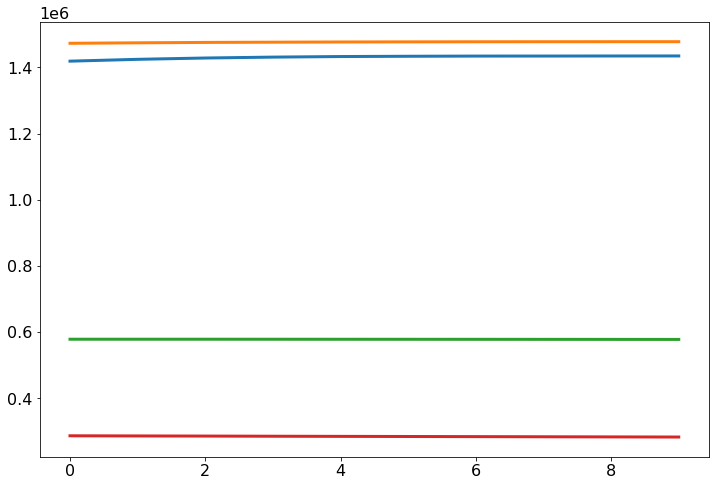

In [138]:
plt.figure()
plt.plot(df_heat_reva_pop+df_heat_vacc_pop+df_heat_unva_pop) 
# plt.plot(df_heat_vacc_pop) 
# plt.plot(df_heat_unva_pop) 

In [139]:

levelsToShow = [0,1,5,10,25,50]
levelsToShow = [0,5,10,25,50,100,200]
levelsToShow = [0,5,10,25,50,100,120]
# levelsToShow = [0,5,10,25,50,100]
hex_colors = sns.light_palette('navy', n_colors=len(levelsToShow) , as_cmap=False).as_hex()
hex_colors = sns.light_palette("#ff4040", n_colors=len(levelsToShow) , as_cmap=False).as_hex()
# hex_colors = sns.light_palette('DarkBlue', n_colors=len(levelsToShow) , as_cmap=False).as_hex()
# hex_colors = sns.light_palette(("#ffffff","#0000ff","#000000"), n_colors=len(levelsToShow) , as_cmap=False).as_hex()
# hex_colors = sns.light_palette(, n_colors=len(levelsToShow) , as_cmap=False).as_hex()

new_hex_colors = []
curVal = 0
for k in range(len(levelsToShow)-1):
    
    curHexColor = hex_colors[k]
    
    nextVal = levelsToShow[k+1] 
    curVal = levelsToShow[k] 
    for n in range(nextVal-curVal):
        new_hex_colors.append(curHexColor)

        
hex_colors

['#f3f0f0', '#f5d3d3', '#f7b5b5', '#f99898', '#fb7b7b', '#fd5d5d', '#ff4040']

In [140]:
weekNameToUse = np.array(['     Week '+str(x) for x in weekNamesShort])
weekNameToUse_DA = np.array(['     Uge '+str(x) for x in weekNamesShort])
weekNameToUse = weekNameToUse[indexToStart:]
weekNameToUse_DA = weekNameToUse_DA[indexToStart:]

weekNameToUse_short = np.array(['Week '+str(x) for x in weekNamesShort])
weekNameToUse_DA_short = np.array(['Uge '+str(x) for x in weekNamesShort])
weekNameToUse_short = weekNameToUse_short[indexToStart:]
weekNameToUse_DA_short = weekNameToUse_DA_short[indexToStart:]

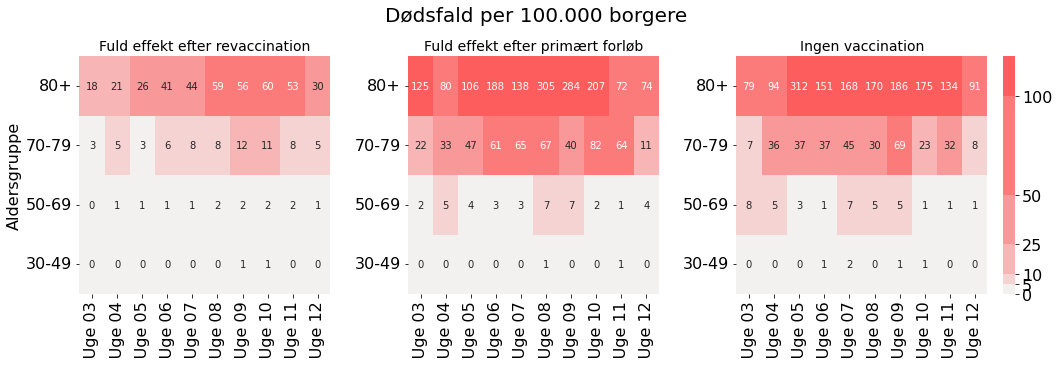

In [141]:

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5.5))


cmap = colors.LinearSegmentedColormap.from_list('Custom', new_hex_colors, len(new_hex_colors))

plotdf = df_heat_reva.copy() 
g = sns.heatmap(plotdf.transpose(),
                ax=ax1,
                annot=True,
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax1.collections[0].colorbar
cbar.set_ticks(levelsToShow[:-1])

plotdf = df_heat_vacc.copy() 
g = sns.heatmap(plotdf.transpose(),
                ax=ax2,
                annot=True,
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax2.collections[0].colorbar
cbar.set_ticks(levelsToShow[:-1])

plotdf = df_heat_unva.copy() 
g = sns.heatmap(plotdf.transpose(),
                ax=ax3,
                annot=True,
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax3.collections[0].colorbar
cbar.set_ticks(levelsToShow[:-1])
# cbar.set_ticks(levelsToShow[:-1])

fig.axes[3].set_visible(False)
fig.axes[4].set_visible(False)

ax1.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax2.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax3.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)

ax1.set_title(sReva,fontsize=14)
ax2.set_title(sFull,fontsize=14)
ax3.set_title(sNone,fontsize=14)

fig.suptitle('Dødsfald per 100.000 borgere',fontsize=20)

ax1.set_ylabel('Aldersgruppe')

plt.tight_layout()

In [142]:
# # annodf_unva
# plotdf.transpose()

# curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# curDeaths

# display(df_heat_unva_count)
# display(df_heat_unva_pop.round().astype(int))

pop_unva = df_heat_unva_pop.round().astype(int)
pop_vacc = df_heat_vacc_pop.round().astype(int)
pop_reva = df_heat_reva_pop.round().astype(int)
for col in pop_unva.columns:
    pop_unva[col] = pop_unva[col].apply(lambda x: f'{x:,}').str.replace(',','.')
    pop_vacc[col] = pop_vacc[col].apply(lambda x: f'{x:,}').str.replace(',','.')
    pop_reva[col] = pop_reva[col].apply(lambda x: f'{x:,}').str.replace(',','.')
    

anno_unva = '\n'+df_heat_unva_count.astype(str)+' ud af\n'+pop_unva
anno_vacc = '\n'+df_heat_vacc_count.astype(str)+' ud af\n'+pop_vacc
anno_reva = '\n'+df_heat_reva_count.astype(str)+' ud af\n'+pop_reva
# anno_unva = '\n\n'+df_heat_unva_count.astype(str)+' ud af\n'+df_heat_unva_pop.round().astype(int).astype(str)
# anno_vacc = '\n\n'+df_heat_vacc_count.astype(str)+' ud af\n'+df_heat_vacc_pop.round().astype(int).astype(str)
# anno_reva = '\n\n'+df_heat_reva_count.astype(str)+' ud af\n'+df_heat_reva_pop.round().astype(int).astype(str)
# asdf =df_heat_reva_pop.round().astype(int)
# asdf['80+'].apply(lambda x: f'{x:,}')
# asdf.iloc[:,:].apply(lambda x: f'{x:,}')
# asdf
# asdf.style.format('{:,}')
# asdf.astype(str).apply(lambda x: x.str.replace(',','.'))
# pop_unva

anno_unva_en = '\n'+df_heat_unva_count.astype(str)+' out of\n'+pop_unva
anno_vacc_en = '\n'+df_heat_vacc_count.astype(str)+' out of\n'+pop_vacc
anno_reva_en = '\n'+df_heat_reva_count.astype(str)+' out of\n'+pop_reva

anno_vacc


,30-49,50-69,70-79,80+
0,\n1 ud af\n634.710,\n4 ud af\n181.622,\n4 ud af\n22.420,\n13 ud af\n11.488
1,\n1 ud af\n512.939,\n7 ud af\n137.521,\n5 ud af\n18.117,\n7 ud af\n9.712
2,\n1 ud af\n423.475,\n4 ud af\n112.715,\n6 ud af\n15.208,\n8 ud af\n8.465
3,\n1 ud af\n368.907,\n3 ud af\n98.833,\n7 ud af\n13.648,\n13 ud af\n7.791
4,\n1 ud af\n344.629,\n3 ud af\n91.914,\n7 ud af\n12.812,\n9 ud af\n7.355
5,\n2 ud af\n333.550,\n6 ud af\n88.228,\n7 ud af\n12.383,\n19 ud af\n7.095
6,\n0 ud af\n326.361,\n6 ud af\n85.883,\n4 ud af\n12.025,\n17 ud af\n6.896
7,\n0 ud af\n321.994,\n2 ud af\n84.573,\n8 ud af\n11.827,\n12 ud af\n6.759
8,\n2 ud af\n317.549,\n1 ud af\n83.361,\n6 ud af\n11.636,\n4 ud af\n6.635
9,\n1 ud af\n314.056,\n3 ud af\n82.530,\n1 ud af\n11.505,\n4 ud af\n6.570


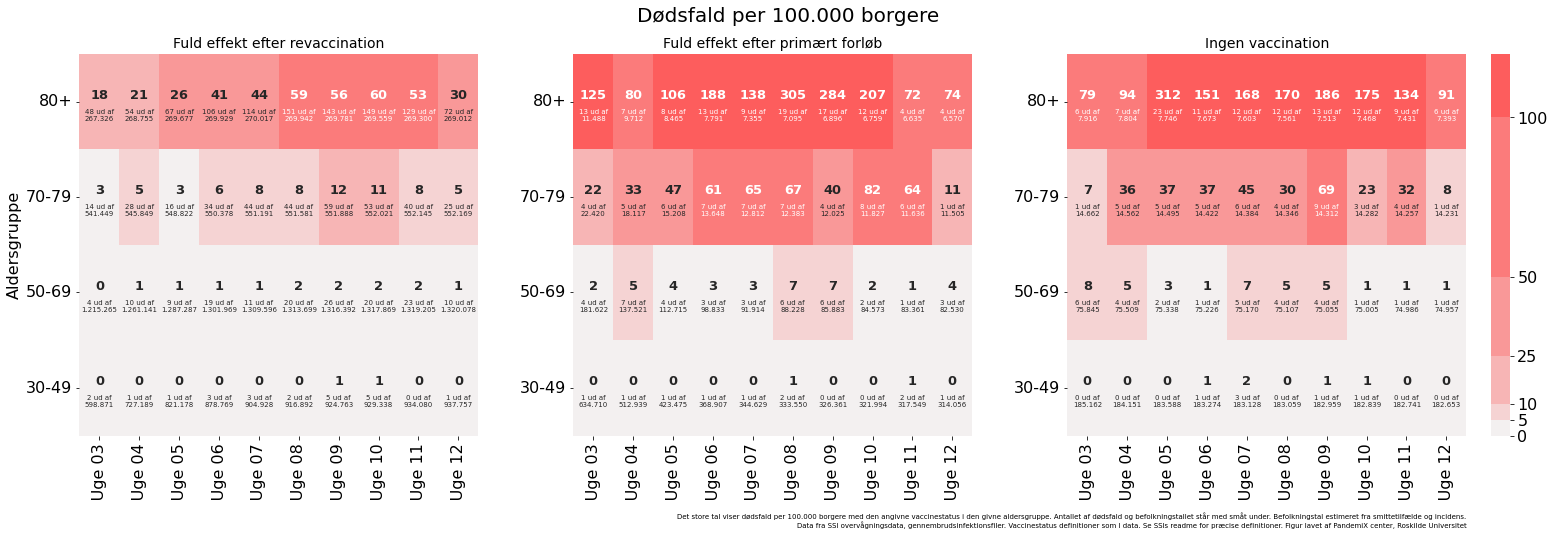

In [143]:

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,7.5))
# fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))


cmap = colors.LinearSegmentedColormap.from_list('Custom', new_hex_colors, len(new_hex_colors))

plotdf = df_heat_reva.copy() 
g = sns.heatmap(data=plotdf.transpose(),
                ax=ax1,
                annot=anno_reva.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g = sns.heatmap(plotdf.transpose(),
                ax=ax1,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax1.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])


# Two vacc
plotdf = df_heat_vacc.copy() 

g = sns.heatmap(data=plotdf.transpose(),
                ax=ax2,
                annot=anno_vacc.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g = sns.heatmap(plotdf.transpose(),
                ax=ax2,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax2.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])



# Unvaccinated
plotdf = df_heat_unva.copy() 

g = sns.heatmap(data=plotdf.transpose(),
                ax=ax3,
                annot=anno_unva.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g.invert_yaxis()

       
g = sns.heatmap(plotdf.transpose(),
                ax=ax3,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse_DA,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax3.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])
# cbar.set_ticks(levelsToShow[:-1])

fig.axes[3].set_visible(False)
fig.axes[4].set_visible(False)

ax1.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax2.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax3.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)

ax1.set_title(sReva,fontsize=14)
ax2.set_title(sFull,fontsize=14)
ax3.set_title(sNone,fontsize=14)

fig.suptitle('Dødsfald per 100.000 borgere',fontsize=20)

ax1.set_ylabel('Aldersgruppe')

plt.tight_layout()

txt1 = 'Det store tal viser dødsfald per 100.000 borgere med den angivne vaccinestatus i den givne aldersgruppe. Antallet af dødsfald og befolkningstallet står med småt under. Befolkningstal estimeret fra smittetilfælde og incidens.\nData fra SSI overvågningsdata, gennembrudsinfektionsfiler. Vaccinestatus definitioner som I data. Se SSIs readme for præcise definitioner. Figur lavet af PandemiX center, Roskilde Universitet'
# txt1 = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: /Kommunalt_DB/07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv.'
ax3.text(1, -0.2,txt1,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax3.transAxes,
     fontsize=7)


if saveFigures:
    fig.savefig(path_figs+'HeatmapDoedsfald')

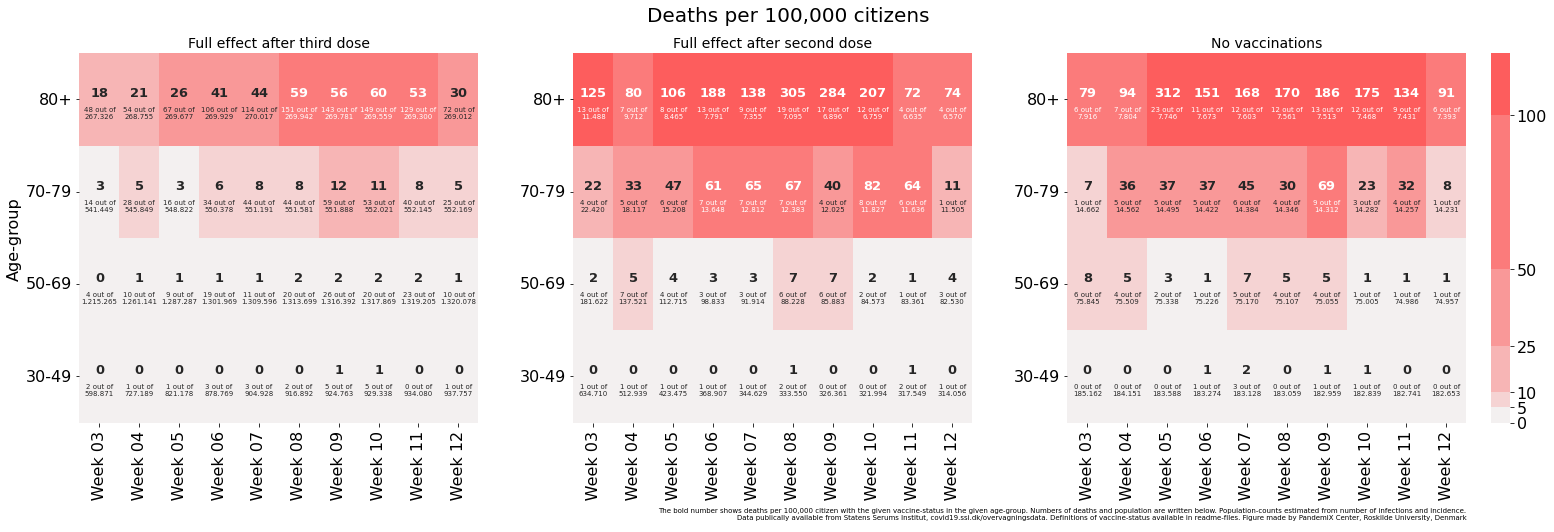

In [144]:

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,7.5))
# fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))


cmap = colors.LinearSegmentedColormap.from_list('Custom', new_hex_colors, len(new_hex_colors))

plotdf = df_heat_reva.copy() 
g = sns.heatmap(data=plotdf.transpose(),
                ax=ax1,
                annot=anno_reva_en.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g = sns.heatmap(plotdf.transpose(),
                ax=ax1,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax1.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])


# Two vacc
plotdf = df_heat_vacc.copy() 

g = sns.heatmap(data=plotdf.transpose(),
                ax=ax2,
                annot=anno_vacc_en.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g = sns.heatmap(plotdf.transpose(),
                ax=ax2,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax2.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])



# Unvaccinated
plotdf = df_heat_unva.copy() 

g = sns.heatmap(data=plotdf.transpose(),
                ax=ax3,
                annot=anno_unva_en.transpose(),
                annot_kws={'va':'top',"fontsize":7},
                fmt='',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,
                cbar=False,
                )
                
g.invert_yaxis()

       
g = sns.heatmap(plotdf.transpose(),
                ax=ax3,
                annot=plotdf.transpose(),
                annot_kws={'va':'bottom',"fontsize":13,'fontweight':'bold'},
                fmt='1.0f',
                vmax=levelsToShow[-1],
                xticklabels=weekNameToUse,
                yticklabels=ageGroupsGroupedNames[1:],
                cmap=cmap,)
                
g.invert_yaxis()
cbar = ax3.collections[1].colorbar
cbar.set_ticks(levelsToShow[:-1])
# cbar.set_ticks(levelsToShow[:-1])

fig.axes[3].set_visible(False)
fig.axes[4].set_visible(False)

ax1.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax2.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)
ax3.set_yticklabels(ageGroupsGroupedNames[1:],rotation=0)

# ax1.set_title(sReva,fontsize=14)
# ax2.set_title(sFull,fontsize=14)
# ax3.set_title(sNone,fontsize=14)
ax1.set_title('Full effect after third dose',fontsize=14)
ax2.set_title('Full effect after second dose',fontsize=14)
ax3.set_title('No vaccinations',fontsize=14)

fig.suptitle('Deaths per 100,000 citizens',fontsize=20)

ax1.set_ylabel('Age-group')

plt.tight_layout()

# txt1 = 'Det store tal viser dødsfald per 100.000 borgere med den angivne vaccinestatus i den givne aldersgruppe. Antallet af dødsfald og befolkningstallet står med småt under. Befolkningstal estimeret fra smittetilfælde og incidens.\nData fra SSI overvågningsdata, gennembrudsinfektionsfiler. Vaccinestatus definitioner som I data. Se SSIs readme for præcise definitioner. PandemiX center, Roskilde Universitet'
txt1 = 'The bold number shows deaths per 100,000 citizen with the given vaccine-status in the given age-group. Numbers of deaths and population are written below. Population-counts estimated from number of infections and incidence.\nData publically available from Statens Serums Institut, covid19.ssi.dk/overvagningsdata. Definitions of vaccine-status available in readme-files. Figure made by PandemiX Center, Roskilde University, Denmark'
ax3.text(1, -0.23,txt1,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax3.transAxes,
     fontsize=7)


if saveFigures:
    fig.savefig(path_figs+'HeatmapDeaths')

In [145]:

# i = -1
# curAge = ageGroupsGrouped[i]
# curName = ageGroupsGroupedNames[i]

# # ax = allAxes.flatten()[0]
# curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
# # ax.plot(weekDTs,curDeaths,'.-',label='Ingen vaccination')
# # curDeaths = getTimeSeries(df2_D,curStatus=sTwo,curAge=curAge)
# # ax.plot(weekDTs,curDeaths,'.-',label='To eller tre vaccinationer')

# # ax.set_title(curAge)

# curInci = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
# # ax.plot(weekDTs,curInci,'.-',label='Ingen vaccination')
# # curInci = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)
# # ax.plot(weekDTs,curInci,'.-',label='To eller tre vaccinationer')
# # addWeekends(ax)


# Old

In [146]:

# def getIncidenceSum(data='Deaths',curStatus=sNone,curAge='Alle',startIndex=0):
#     if data=='Deaths':
#         thisdf_2 = df2_D 
#         thisdf_3 = df3_D 
#     else:
#         thisdf_2 = df2_C
#         thisdf_3 = df3_C
        
#     if (type(curAge)==str):
#         return getTimeSeries(thisdf_3,curStatus,curAge)[startIndex:].sum()
#     else:
#         curTotCount = getTimeSeries(thisdf_2,curStatus,curAge)[startIndex:].sum()
#         curPopEsti = estimatePopCount(curStatus,curAge)
        
#         return 100000 * curTotCount / curPopEsti
        
       

In [147]:
# # Same figure as above, but with labels with population counts

# firstIndexToUse = np.where([x == '01' for x in weekNamesShort])[0][0]

# curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)

# allCount_unvacc = []
# allCount_vacc = []
# allInci_unvacc = []
# allInci_vacc = []

# popCounts_unvacc = []
# popCounts_vacc = []
# for i in range(len(ageGroupsGrouped)):
#     curAge = ageGroupsGrouped[i]
#     curName = ageGroupsGroupedNames[i]
    
#     curDeaths = getTimeSeries(df2_D,curStatus=sNone,curAge=curAge)
#     count_unvacc = curDeaths[firstIndexToUse:].sum()
#     curDeaths = getTimeSeries(df2_D,curStatus=sTwo,curAge=curAge)
#     count_vacc = curDeaths[firstIndexToUse:].sum()
    
#     # curDeaths = getTimeSeries(df3_D,curStatus=sNone,curAge=curAge)
#     # inci_unvacc = curDeaths[firstIndexToUse:].sum()
#     # curDeaths = getTimeSeries(df3_D,curStatus=sTwo,curAge=curAge)
#     # inci_vacc = curDeaths[firstIndexToUse:].sum()
#     inci_unvacc = getIncidenceSum('Deaths',sNone,curAge,firstIndexToUse)
#     inci_vacc = getIncidenceSum('Deaths',sTwo,curAge,firstIndexToUse)
    
#     # Scale to % instead of per 100.000
#     inci_unvacc = inci_unvacc/1000
#     inci_vacc = inci_vacc/1000
    
#     allCount_unvacc.append(count_unvacc)
#     allCount_vacc.append(count_vacc)
#     allInci_unvacc.append(inci_unvacc)
#     allInci_vacc.append(inci_vacc)
    
#     # popCounts_unvacc.append(estimatePopCount(sNone,curAge))
#     # popCounts_vacc.append(estimatePopCount(sTwo,curAge))
#     popCounts_unvacc.append(estimatePopCount(sNone,curAge,firstIndexToUse))
#     popCounts_vacc.append(estimatePopCount(sTwo,curAge,firstIndexToUse))
    
# fig,(ax1,ax2) = plt.subplots(2,1)

# fig.patch.set_facecolor('xkcd:off white')
# for ax in (ax1,ax2):
#     ax.set_facecolor('xkcd:off white')

# dX = 0.2
    
# curX = np.arange(len(ageGroupsGroupedNames))
# ax1.bar(curX-dX,allCount_unvacc,width=2*dX,color='xkcd:purple',label='Ingen vaccination')
# ax1.bar(curX+dX,allCount_vacc,width=2*dX,color='xkcd:dark orange',label='To eller tre vaccinationer')
# ax1.set_xticks(curX)
# ax1.set_xticklabels(ageGroupsGroupedNames)

# ax2.bar(curX-dX,allInci_unvacc,width=2*dX,color='xkcd:purple',label='Ingen vaccination')
# ax2.bar(curX+dX,allInci_vacc,width=2*dX,color='xkcd:dark orange',label='To eller tre vaccinationer')
# ax2.set_xticks(curX)
# ax2.set_xticklabels(ageGroupsGroupedNames)


# # Round popcounts to nearest hundred
# popCounts_unvacc = [int(np.round(x/100))*100 for x in popCounts_unvacc]
# popCounts_vacc = [int(np.round(x/100))*100 for x in popCounts_vacc]
# # popCounts_unvacc = [int(np.round(x/1000))*1000 for x in popCounts_unvacc]
# # popCounts_vacc = [int(np.round(x/1000))*1000 for x in popCounts_vacc]
# # popCounts_unvacc = [int(np.round(x/1000)) for x in popCounts_unvacc]
# # popCounts_vacc = [int(np.round(x/1000)) for x in popCounts_vacc]
# # Add counts to figure
# for i in curX:
#     ax1.text(i-dX,allCount_unvacc[i]+2,allCount_unvacc[i],ha='center')
#     ax1.text(i+dX,allCount_vacc[i]+2,allCount_vacc[i],ha='center')
    
#     curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]:n}'
#     ax2.text(i-dX,allInci_unvacc[i]+10,curStr,ha='center')
#     curStr = f'{allCount_vacc[i]} ud af\n{popCounts_vacc[i]:n}'
#     ax2.text(i+dX,allInci_vacc[i]+10,curStr,ha='center')
#     # curStr = f'{allCount_unvacc[i]} ud af\n{popCounts_unvacc[i]} tusind'
#     # ax2.text(i-dX,allInci_unvacc[i]+10,curStr,ha='center')
#     # curStr = f'{allCount_vacc[i]} ud af\n{popCounts_vacc[i]} tusind'
#     # ax2.text(i+dX,allInci_vacc[i]+10,curStr,ha='center')

# ax2.set_ylim(top=allInci_unvacc[-1]*1.2)

# ax1.set_ylabel('Antal dødsfald')
# # ax2.set_ylabel('Dødsfald per 100.000')
# ax2.set_ylabel('Andel af befolkning [%]')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')

# ax1.set_axisbelow(True)
# ax2.set_axisbelow(True)
# ax1.grid(axis='y')
# ax2.grid(axis='y')

# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# strTitle = f'Danske COVID-19 registrerede dødsfald\nPeriode fra og med uge {weekNamesShort[firstIndexToUse]} til og med uge {weekNamesShort[-1]}'
# fig.suptitle(strTitle,fontsize=20)

# txt1 = 'Kategorien "Første vaccination" er udeladt grundet små tal. Bemærk: Nøjagtige befolkningstal fordelt på vaccinationsstatus er ikke tilgængelige,\nog er her estimeret ud fra 4-ugers gennemsnit af antal og incidens per 100.000 og derefter afrundet til nærmeste hundrede.\nRasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet. Data fra SSI overvågningsdata, gennembrudsdatafiler.'
# ax2.text(1, -0.14,txt1,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax2.transAxes,
#      fontsize=7)
     
# fig.tight_layout()

# # if saveFigures:
# #     fig.savefig(path_figs+'AgeDistribution\\DoesdfaldPerVaccinestatusOgAlder')